In [1]:
#import libraries
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import matplotlib as mpl
import keras.backend as K
import pandas as pd
import logomaker as lm
import seaborn as sns
import math as mt
from keras.models import load_model
from numpy.lib.stride_tricks import as_strided

2023-06-30 12:01:42.764814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 12:01:42.828218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 12:01:43.150569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell3/anaconda3/envs/workenv/lib/
2023-06-30 12:01:43.150616: W tensorflow/compiler/xla/str

In [2]:
def ohd(seq):
    seq2=list()
    mapping = {"[1 0 0 0]":"A", "[0 1 0 0]":"C", "[0 0 1 0]":"G", "[0 0 0 1]":"T"}
    for i in seq:
        seq2.append(mapping[str(i)] if str(i) in mapping.keys() else "x")
    return ''.join(seq2)

def ohd_loc(seq):
    seq2=list()
    mapping = {"0":"A", "1":"C", "2":"G", "3":"T"}
    for i in seq:
        seq2.append(mapping[str(i)] if str(i) in mapping.keys() else "x")
    return ''.join(seq2)

def compute_gc_content(one_hot_sequence):
    gc_count = sum(base[1]+base[2] for base in one_hot_sequence)
    gc_content = gc_count / len(one_hot_sequence)
    return gc_content

def fast_pred(input,model):
    return model(tf.expand_dims(tf.cast(input,tf.float32),0))

def fast_pred_seq(input,window_start,model,size=2001):
    X=[]
    for i in range(window_start,window_start+size):
        X.append(np.array(fast_pred(input[i-(size//2):i+(size//2)+1],model))[0][0])
    return(X)

def fast_pred_whole_seq(input,model,size=2001):
    X=[]
    length=len(np.array(input))
    for i in range(size//2,length-(size//2)):
        X.append(np.array(fast_pred(input[i-(size//2):i+(size//2)+1],model))[0])
    return([0 for i in range(0,size//2,10)] + X +[0 for i in range(0,size//2,10)])

def get_max(array,n):
    return ((-array).argsort()[:n])

def get_min(array,n):
    return (array.argsort()[:n])

def mutation(window_start,chr, vals, size=2001):
    mut=np.copy(chr)
    for i in vals:
        if 0 < i <= size:
            mut[i+window_start]=np.roll(mut[i+window_start],1)
        elif 2001 < i <= 2*size:
            mut[i+window_start-size]=np.roll(mut[i+window_start-size],1)
        elif 4002 < i <= 3*size:
            mut[i+window_start-2*size]=np.roll(mut[i+window_start-2*size],1)
        else:
            mut[i+window_start-3*size]=np.roll(mut[i+window_start-3*size],1)
    return mut

def aimed_mutation(window_start,chr, vals,size=2001):
    mut=np.copy(chr)
    for i in vals:
        if 0 < i <= size:
            mut[i+window_start]=[1,0,0,0]
        elif 2001 < i <= 2*size:
            mut[i+window_start-size]=[0,1,0,0]
        elif 4002 < i <= 3*size:
            mut[i+window_start-2*size]=[0,0,1,0]
        else:
            mut[i+window_start-3*size]=[0,0,0,1]
    return mut

def compute_saliency_map(input_seq, model):
    # Compute the gradients of the output with respect to the input
    input_seq=tf.cast(input_seq,tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        output = model(tf.expand_dims(input_seq,0))
    grads = tape.gradient(output, input_seq)
    

    # Compute the saliency map
    saliency_map = grads #tf.multiply(input_seq, grads)

    # Sum the saliency map over the channel dimension
    saliency_map = tf.reduce_sum(saliency_map, axis=-1)
    return saliency_map

def compute_saliency_channels(input_seq, model):
    # Compute the gradients of the output with respect to the input
    input_seq=tf.cast(input_seq,tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        output = model(tf.expand_dims(input_seq,0))
    grads = tape.gradient(output, input_seq)

    # Compute the saliency map
    saliency_map = grads #tf.multiply(input_seq, grads)
    
    return saliency_map

def window_map(input,window_start,model,size=2001):
    model=model
    Y=np.zeros(size*2)
    for i in range (-(size//2),size//2):
        x=np.array(compute_saliency_map(tf.cast(input[window_start+i:window_start+size+i],tf.float32),model))
        y=np.concatenate((np.zeros(size//2+i),x,np.zeros(size//2+1-i)))
        Y=np.vstack([Y,y])
    return(Y)

def sliding_window_view(x, window_shape, axis = None, *,
                        
                        subok=False, writeable=False):

    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

def kmer_counts(one_hots, k, order='ACGT', includeN=True, as_pandas=True):
    """Compute kmer occurences in one-hot encoded sequence."""
    # Convert input into list-like of one_hot 2D-arrays
    # If 3D-array optionnally use faster implementation
    fast = False
    if isinstance(one_hots, dict):
        one_hots = list(one_hots.values())
    elif isinstance(one_hots, np.ndarray):
        if one_hots.ndim == 2:
            # single array turned into list of one array
            one_hots = [one_hots]
        elif one_hots.ndim == 3:
            # Check that last dimension is 4
            assert one_hots.shape[2] == 4
            fast = True
    if fast:  # Faster on 3D array
        # Initialise kD array
        all_counts = np.zeros(tuple(5 for i in range(k)), dtype=int)
        if k == 1:
            # Count each base
            all_counts[:4] = one_hots.sum(axis=(0, 1))
            # Count leftover as Ns
            all_counts[4] = (len(one_hots) * one_hots.shape[1]
                             - all_counts[:4].sum())
        else:
            # Convert one_hot to integer tokens
            tokens = (np.argmax(one_hots, axis=-1)
                      + 4 * (np.sum(one_hots, axis=-1) != 1))
            # Get kmers with sliding_window_view
            kmers = sliding_window_view(tokens, (1, k)).reshape(-1, k)
            # Count kmers in the kD array
            np.add.at(all_counts, tuple(kmers[:, i] for i in range(k)), 1)
    else:  # Iterate over one-hot encoded arrays
        # Initialise kD array
        all_counts = np.zeros(tuple(5 for i in range(k)), dtype=int)
        for oh in one_hots:
            # Check that arrays are 2D with a shape of 4 in the 2nd dimension
            assert oh.ndim == 2
            assert oh.shape[1] == 4
            if k == 1:
                # Count each base
                all_counts[:4] += oh.sum(axis=0)
                # Count leftover as Ns
                all_counts[4] += len(oh) - oh.sum()
            else:
                # Convert one_hot to integer tokens
                tokens = np.argmax(oh, axis=-1) + 4*(np.sum(oh, axis=-1) != 1)
                # Get kmers with sliding_window_view
                kmers = sliding_window_view(tokens, k)
                # Count kmers in the kD array
                np.add.at(all_counts, tuple(kmers[:, i] for i in range(k)), 1)
    # Format output
    if includeN:
        order += 'N'
    else:
        all_counts = all_counts[tuple(slice(0, -1) for i in range(k))]
    if as_pandas:
        ser = pd.Series(
            all_counts.ravel(),
            index=pd.MultiIndex.from_product([list(order)]*k))
        return ser.sort_index()
    else:
        return all_counts
    
def create_peak(input_seq, start, maxed_model, inhibited_model):
    #create peak for KC
    stop= start+2001

    mod_loop=np.copy(input_seq)
    salMAX=compute_saliency_channels(mod_loop[start:stop],maxed_model)
    salMAX=salMAX - np.mean(salMAX, axis=1, keepdims=True)
    salMAX=np.array(salMAX-(salMAX*input_seq[start:stop]))
    salMAX[salMAX<0]=0

    salMIN=compute_saliency_channels(mod_loop[start:stop],inhibited_model)
    salMIN=salMIN - np.mean(salMIN, axis=1, keepdims=True)
    salMIN=np.array(salMIN-(salMIN*input_seq[start:stop]))
    salMIN[salMIN>0]=0

    mod_sal=salMAX*salMIN
    mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
    mod_vals_idx=get_min(mod_vals,1)
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    best_pred=fast_pred(mod_M_2L[start:stop],maxed_model)

    for i in range(2000):
        mod_loop=np.copy(mod_M_2L)
        salMAX=compute_saliency_channels(mod_loop[start:stop],maxed_model)
        salMAX=salMAX - np.mean(salMAX, axis=1, keepdims=True)
        salMAX=np.array(salMAX-(salMAX*mod_loop[start:stop]))
        salMAX[salMAX<0]=0

        salMIN=compute_saliency_channels(mod_loop[start:stop],inhibited_model)
        salMIN=salMIN - np.mean(salMIN, axis=1, keepdims=True)
        salMIN=np.array(salMIN-(salMIN*mod_loop[start:stop]))
        salMIN[salMIN>0]=0

        sal_loop=np.exp(salMAX)*np.exp(-salMIN)*salMAX*salMIN
        sal_loop[:850] = 0
        sal_loop[1150:] = 0
        prob = sal_loop / np.sum(sal_loop)
        mod_vals = sal_loop.T.ravel()

        mod_vals_value=rd.choices(mod_vals, weights=prob.T.ravel(), k=1)
        mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
        mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
        
        f_pred=fast_pred(mod_M_2L[start:stop],maxed_model)
        if  f_pred > best_pred:
            best_pred=fast_pred(mod_M_2L[start:stop],maxed_model)
            most_pred=mod_M_2L

    return most_pred

In [3]:
def kill_peak(input_seq, start, inhibited_model,strength):
    #kill peak
    stop= start+2001
    seq=np.copy(input_seq)
    sal=compute_saliency_channels(seq[start:stop],inhibited_model)
    vals=np.concatenate((np.array(sal[:,0]),np.array(sal[:,1]),np.array(sal[:,2]),np.array(sal[:,3])))
    vals_idx=get_min(vals,1)
    mod_loop=aimed_mutation(start,seq,vals_idx)
    most_pred=mod_loop
    best_pred=fast_pred(mod_loop[start:stop],inhibited_model)

    for i in range(strength):
        mod_loop=np.copy(mod_loop)
        sal=compute_saliency_channels(mod_loop[start:stop],inhibited_model)
        vals=np.concatenate((np.array(sal[:,0]),np.array(sal[:,1]),np.array(sal[:,2]),np.array(sal[:,3])))
        vals_idx=get_min(vals,1)
        mod_loop=aimed_mutation(start,mod_loop,vals_idx)

        f_pred=fast_pred(mod_loop[start:stop],inhibited_model)   

        if  f_pred < best_pred:
            best_pred=fast_pred(mod_loop[start:stop],inhibited_model)
            most_pred=mod_loop

    return most_pred

def kill_peak_iterations(input_seq, start, inhibited_model,strength):
    #create peak for KC
    stop= start+2001

    mod_loop=np.copy(input_seq)
    salMIN=compute_saliency_channels(mod_loop[start:stop],inhibited_model)
    # salMIN=salMIN - np.mean(salMIN, axis=1, keepdims=True)
    salMIN=np.array(salMIN-(salMIN*input_seq[start:stop]))
    salMIN[salMIN>0]=0
    mod_sal=salMIN
    mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
    mod_vals_idx=get_min(mod_vals,1)
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    best_pred=fast_pred(mod_M_2L[start:stop],inhibited_model)

    for i in range(strength):
        mod_loop=np.copy(mod_M_2L)
        salMIN=compute_saliency_channels(mod_loop[start:stop],inhibited_model)
        # salMIN=salMIN - np.mean(salMIN, axis=1, keepdims=True)
        salMIN=np.array(salMIN-(salMIN*mod_loop[start:stop]))
        salMIN[salMIN>0]=0
        sal_loop=salMIN
        # sal_loop[:850] = 0
        # sal_loop[1150:] = 0
        prob = sal_loop / np.sum(sal_loop)
        mod_vals = sal_loop.T.ravel()

        mod_vals_value=rd.choices(mod_vals, weights=prob.T.ravel(), k=1)
        # mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
        mod_vals_idx=get_min(mod_vals,1)
        mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
        
        f_pred=fast_pred(mod_M_2L[start:stop],inhibited_model)
        if  f_pred < best_pred:
            best_pred=fast_pred(mod_M_2L[start:stop],inhibited_model)
            most_pred=mod_M_2L

    return most_pred

def kill_peak_mut(input_seq, model, start, strength):
    #kill peak
    stop=start+2001
    output_seq=np.copy(input_seq)
    history={}
    history['start']=(fast_pred(output_seq[start:stop],model)[0][0].numpy())#,output_seq)
    for k in range(strength):
        
        least_pred=fast_pred(output_seq[start:stop],model)

        for i in range(len(output_seq[start:stop])):
            for j in range(0,3):
                if j!=output_seq[start:stop][i].argmax():
                    seq=np.copy(output_seq[start:stop])
                    mut=[0,0,0,0]
                    mut[j]+=1
                    seq[i]=mut
                    new_pred=fast_pred(seq,model)
                    if new_pred < least_pred:
                        least_pred=new_pred
                        mut_loc=(i,j)

        mut=[0,0,0,0]
        mut[mut_loc[1]]+=1
        original_base=output_seq[start:stop][mut_loc[0]].argmax()    
        output_seq[start:stop][mut_loc[0]]=mut
        history[str(start+mut_loc[0])+":"+ohd_loc(str(original_base))+'->'+ohd_loc(str(mut_loc[1]))]=(least_pred[0][0].numpy())#,np.copy(output_seq))

    return history

In [4]:
from Bio import SeqIO
from Bio.Seq import Seq

def save_as_fasta(sequence, nom_fichier):
    # Créer un objet Seq à partir de la séquence d'ADN
    seq_obj = Seq(sequence)
    
    # Créer un objet SeqRecord avec l'objet Seq
    seq_record = SeqIO.SeqRecord(seq_obj)
    
    # Ouvrir le fichier en mode écriture
    with open(nom_fichier, "w") as fichier:
        # Écrire le SeqRecord dans le fichier au format FASTA
        SeqIO.write(seq_record, fichier, "fasta")

In [5]:
#load all chrs
X_2L=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
X_2R=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
X_3L=np.load('/home/florian/projet/r6.16/seq.npz')['3L']
X_3R=np.load('/home/florian/projet/r6.16/seq.npz')['3R']
X_4=np.load('/home/florian/projet/r6.16/seq.npz')['4']
X_X=np.load('/home/florian/projet/r6.16/seq.npz')['X']
X_Y=np.load('/home/florian/projet/r6.16/seq.npz')['Y']

In [6]:
#load all models
model_name='new_cut_weightless'
modelALL = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

model_name='new_cut_2001_KC_G'
modelKC_G = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_KC_AB'
modelKC_AB = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_KC_ABp'
modelKC_ABp = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_allKC'
modelallKC = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

model_name='new_cut_2001_T1'
modelT1 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T2'
modelT2 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T2a'
modelT2a = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T3'
modelT3 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T4'
modelT4 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T5'
modelT5 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_allT'
modelallT = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

model_name='new_cut_2001_Subperineurialglia'
modelSubperineurialglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Perineurialglia'
modelPerineurialglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Astrocyte_like'
modelAstrocyte_like = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Cortexglia'
modelCortexglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Ensheathingglia'
modelEnsheathingglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Photoreceptors'
modelPhotoreceptors = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Plasmatocytes'
modelPlasmatocytes = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
modelname='new_cut_2001_Chiasmglia'
modelChiasmglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_allGlia'
modelallGlia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

2023-06-30 12:02:00.514737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 12:02:00.518262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 12:02:00.518342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 12:02:00.519331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [134]:
with np.load('/home/florian/projet/cell_types/scATACseq_Subperineurialglia.dedup.no_blacklist.RPGCnormalized.bw.npz') as f:
    Y_2L=f['2L'][0]
    Y_2R=f['2R'][0]
    Y_3L=f['3L'][0]
    Y_3R=f['3R'][0]
    Y_4=f['4'][0]
    Y_X=f['X'][0]
    Y_Y=f['Y'][0]

# /home/florian/projet/cell_types/scATACseq_KC_G.dedup.no_blacklist.RPGCnormalized.bw.npz
# /home/florian/projet/scATACseq_14chr.npz

cut=50
Y_2L[Y_2L >= cut] = cut
Y_2L=Y_2L/cut
Y_2R[Y_2R >= cut] = cut
Y_2R=Y_2R/cut
Y_3L[Y_3L >= cut] = cut
Y_3L=Y_3L/cut
Y_3R[Y_3R >= cut] = cut
Y_3R=Y_3R/cut
Y_4[Y_4 >= cut] = cut
Y_4=Y_4/cut
Y_X[Y_X >= cut] = cut
Y_X=Y_X/cut
Y_Y[Y_Y >= 80] = 80
Y_Y=Y_Y/80

with np.load('/home/florian/projet/models/preds_new_cut_weightless.npz') as f:
    pred_2L=f['pred2L']
    pred_2R=f['pred2R']
    pred_3L=f['pred3L']
    pred_3R=f['pred3R']
    pred_4=f['pred4']
    pred_X=f['predX']
    pred_Y=f['predY']
  
# 
# /home/florian/projet/models/preds_new_cut_2001_KC_G.npz

In [9]:
a=ohd(X_2L)

In [17]:
os.chdir('/home/florian/projet/designed_sequences')
save_as_fasta(a,'chr2L.fasta')

2023-06-27 14:14:30.764330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-27 14:14:31.336150: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-27 14:14:31.828349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


tf.Tensor([[0.51560134]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.38828957]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.29059997]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.21900822]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.16046464]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.11600244]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.08462019]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.0616646]], shape=(1, 1), dtype=float32)


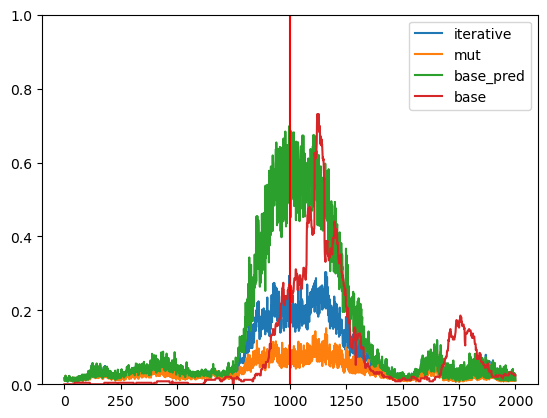

In [27]:
#test
start = 1705500+16200-90
stop = start + 2001
result=kill_peak_mut(X_2L,modelT1,start,8)[0]
result2=kill_peak_iterations(X_2L,start,modelT1,8)
plt.plot(fast_pred_seq(result2,start,modelT1),label="iterative")
plt.plot(fast_pred_seq(result,start,modelT1),label="mut")
plt.plot(fast_pred_seq(X_2L,start,modelT1),label="base_pred")
plt.plot(Y_2L[start:stop],label="base")
plt.axvline(x=1000, color='red')
plt.ylim(0,1)
plt.legend()

chr X

slide 1

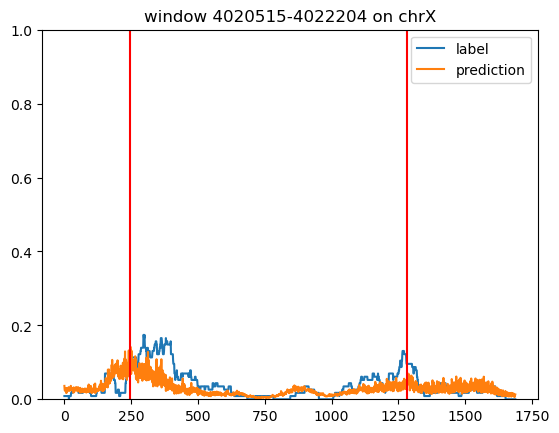

In [11]:
#first peak: chrX KC_ABp
start=4_020_515
stop=4_022_204
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_ABp)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label") #KC_ABp
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

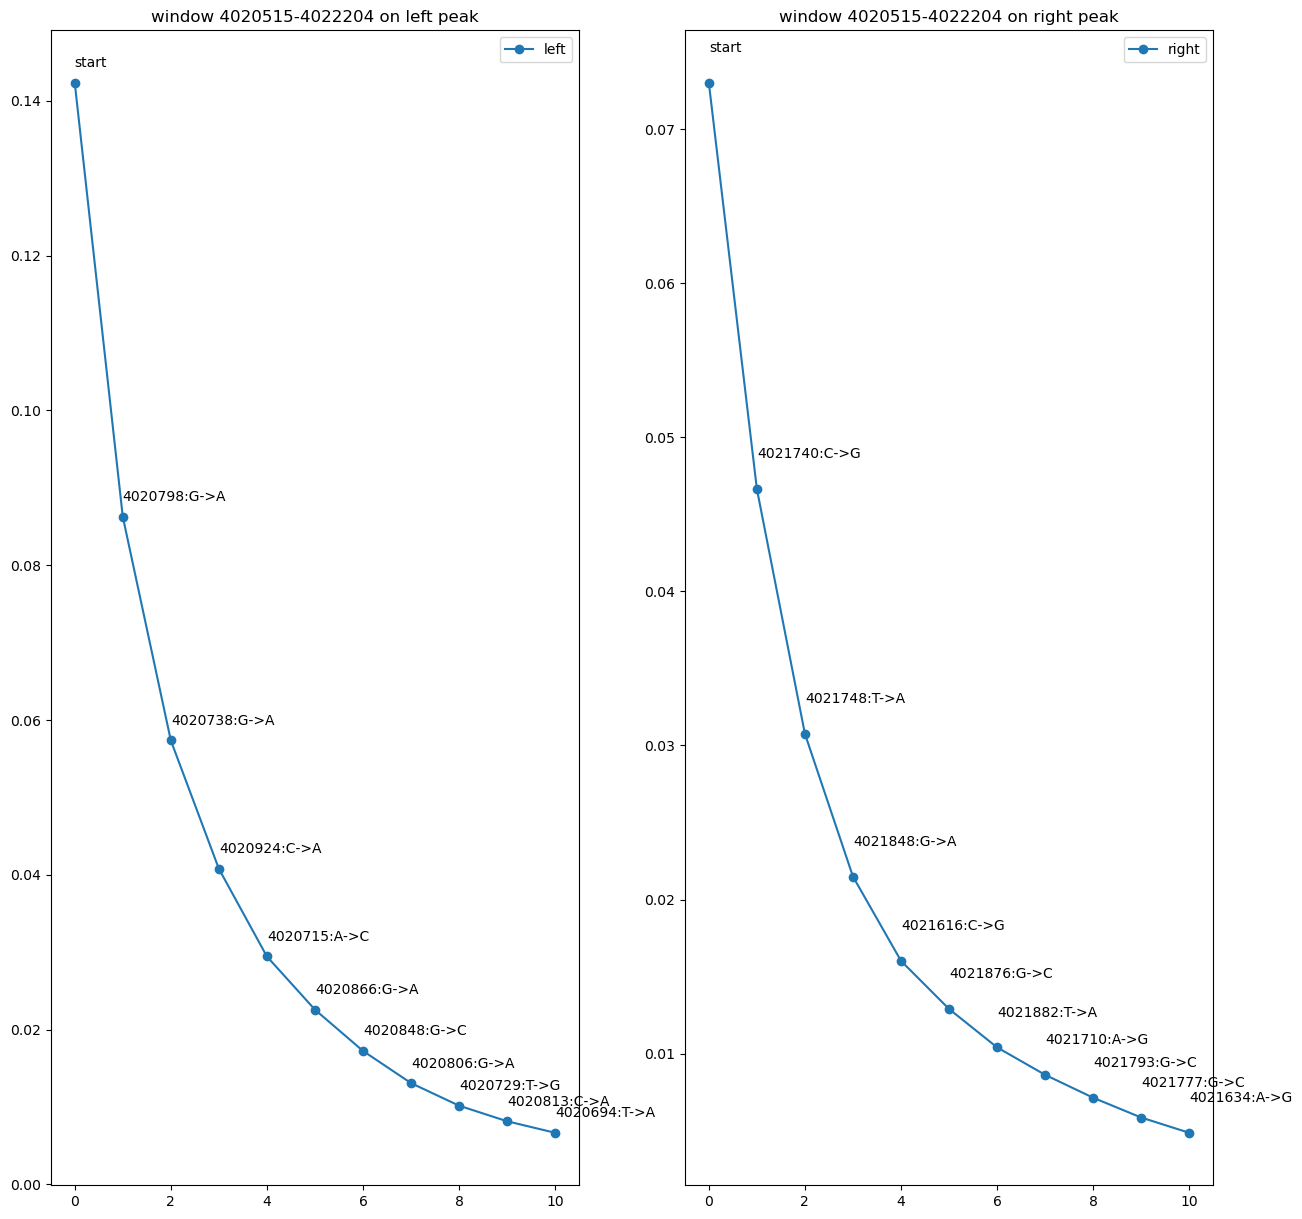

In [15]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_X,modelKC_ABp,real_start_left,10)
result_right=kill_peak_mut(X_X,modelKC_ABp,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

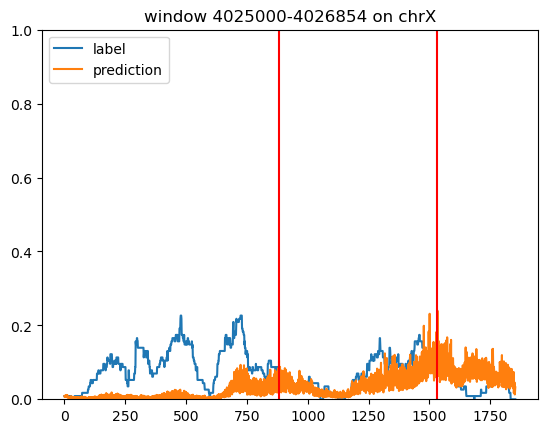

In [17]:
#next peak: chrX KC_ABp
start=4_025_000
stop=4_026_854
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_G)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label")#KC_ABp
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

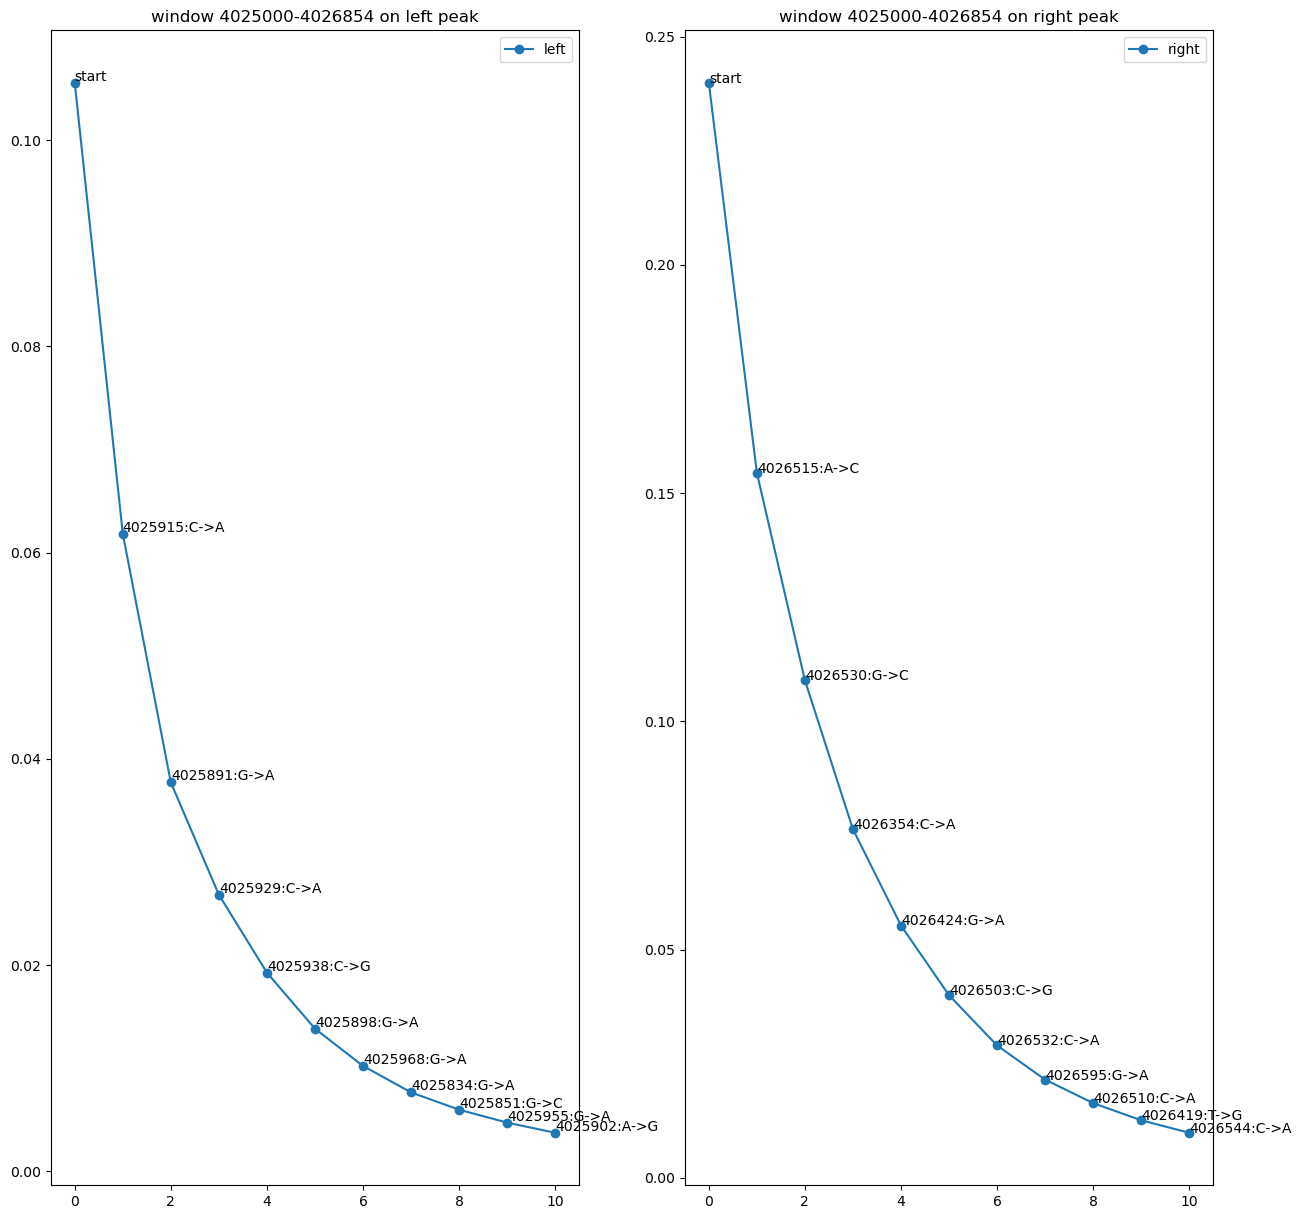

In [19]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_X,modelKC_G,real_start_left,10)
result_right=kill_peak_mut(X_X,modelKC_G,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

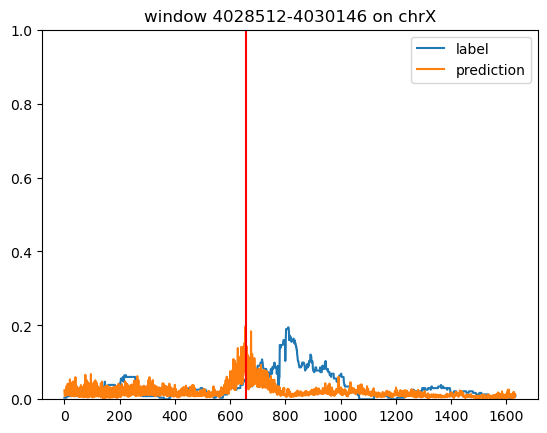

In [22]:
#next peak: chrX KC_ABp and KC_G
start=4_028_512
stop=4_030_146
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelPerineurialglia)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#KC_G
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

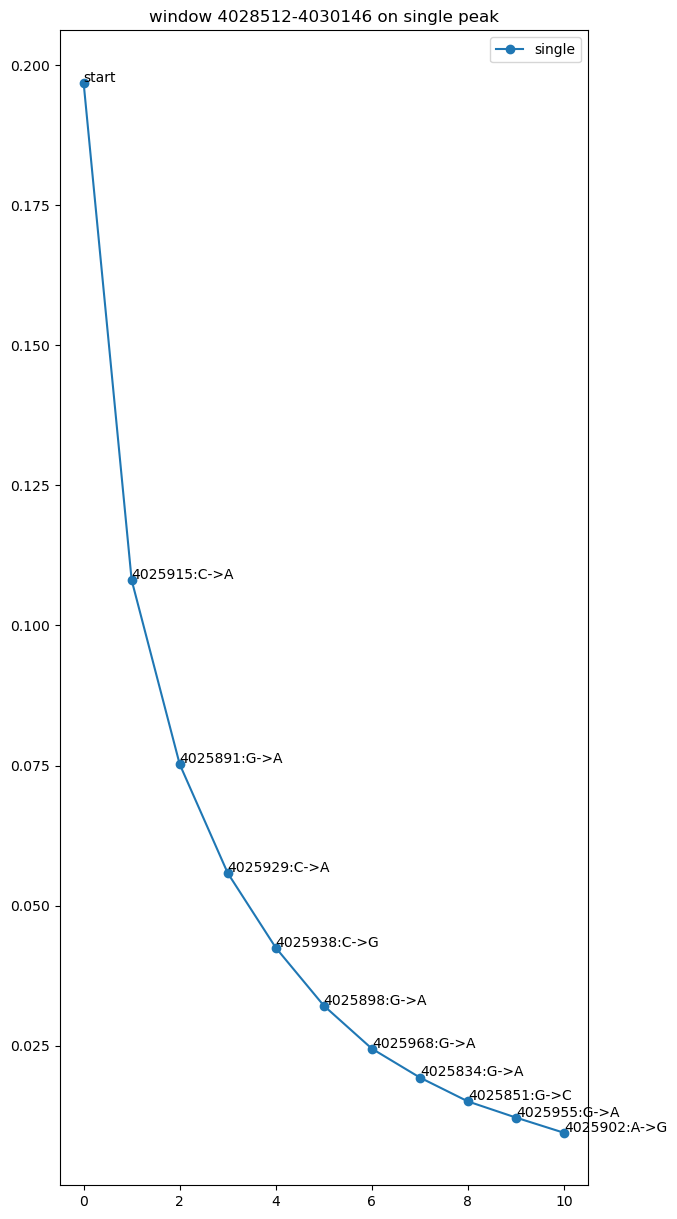

In [23]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelPerineurialglia,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

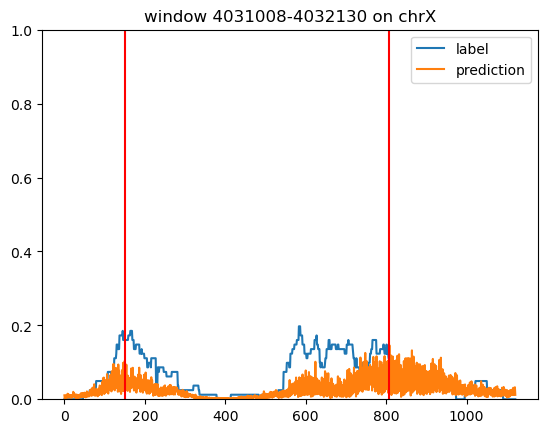

In [28]:
#next peak: chrX all cell types
start=4_031_008
stop=4_032_130
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_G)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label")#T1
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

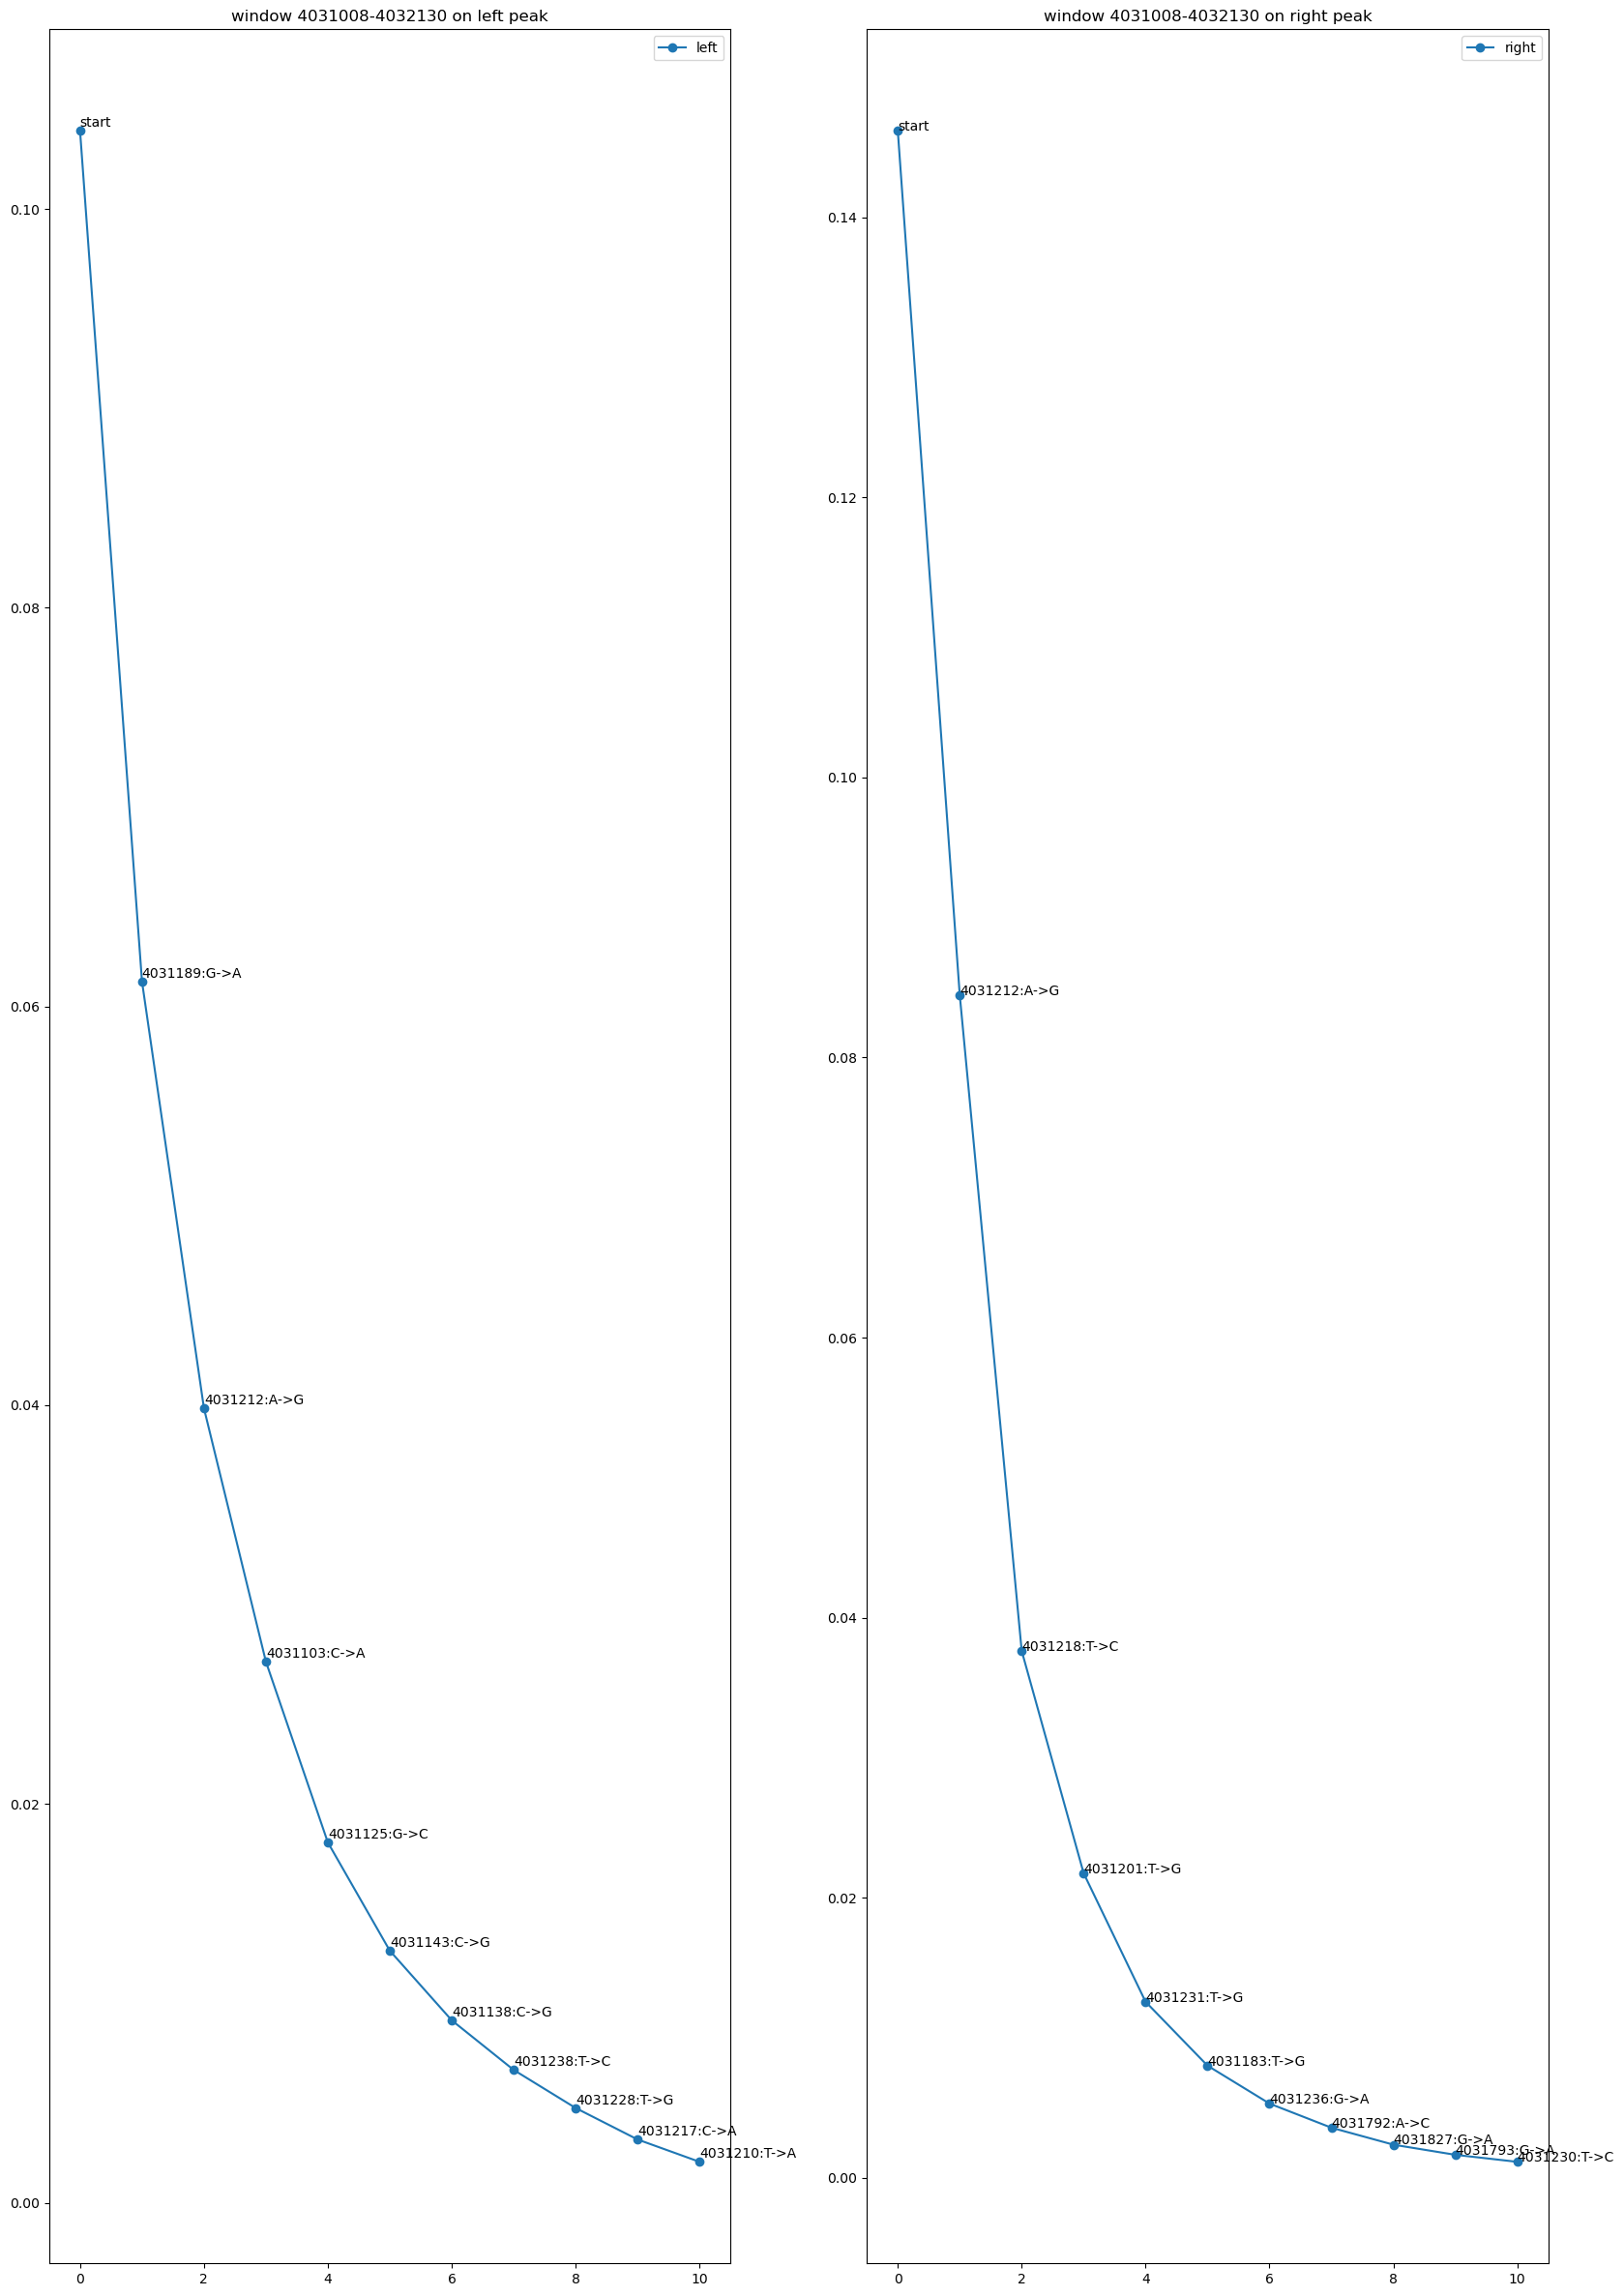

In [38]:
# real_start_left=start+loc_left_max-1000
# real_start_right=start+loc_right_max-1000
# result_left=kill_peak_mut(X_X,modelKC_G,real_start_left,10)
# result_right=kill_peak_mut(X_X,modelKC_G,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(20,30))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

slide 2

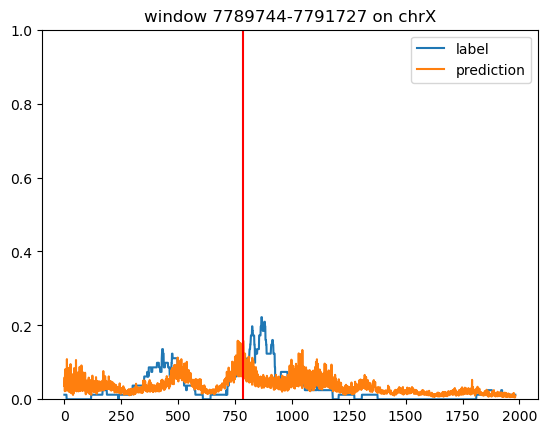

In [39]:
#next peak: chrX all cell types
start=7_789_744
stop=7_791_727
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelT1)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")#T1
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

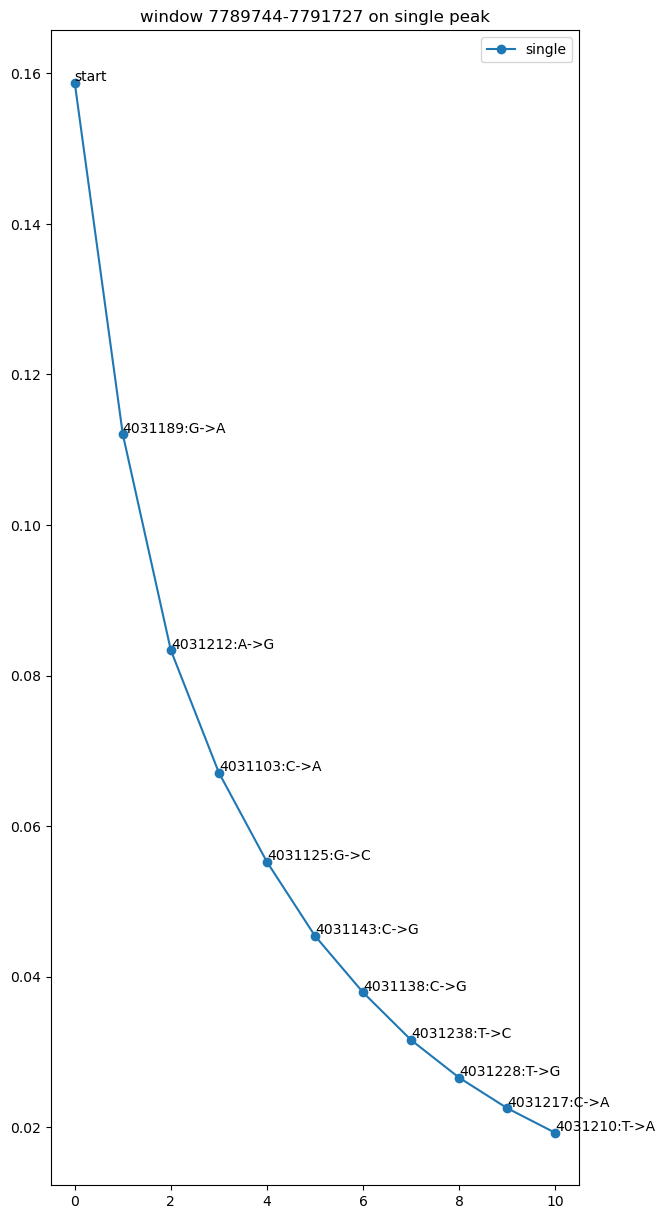

In [40]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelT1,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

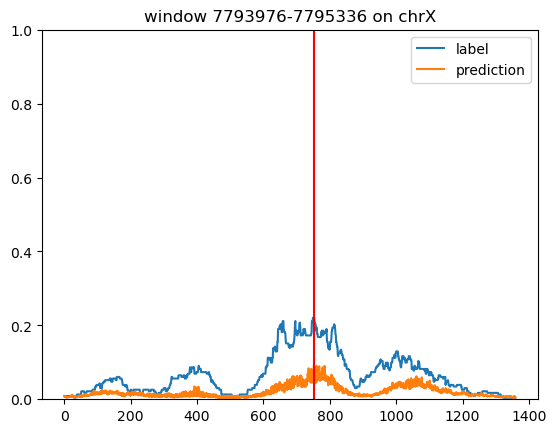

In [44]:
#next peak: chrX KC_G
start=7_793_976
stop=7_795_336
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_AB)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")#KC_G
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

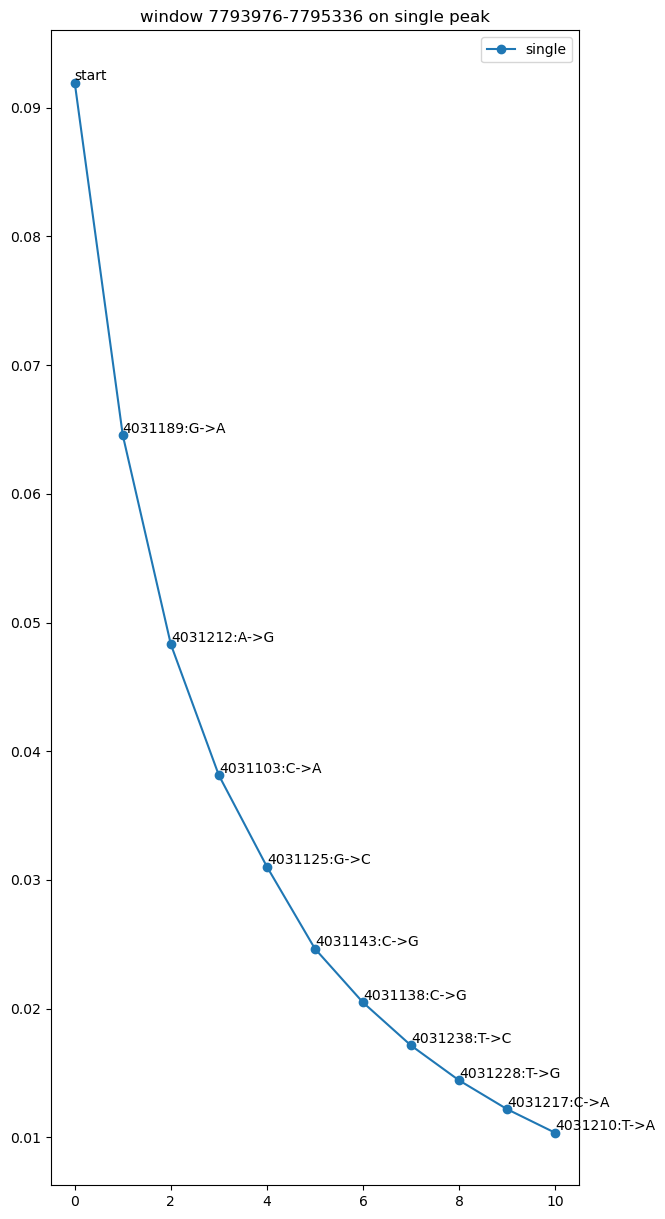

In [46]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelKC_AB,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

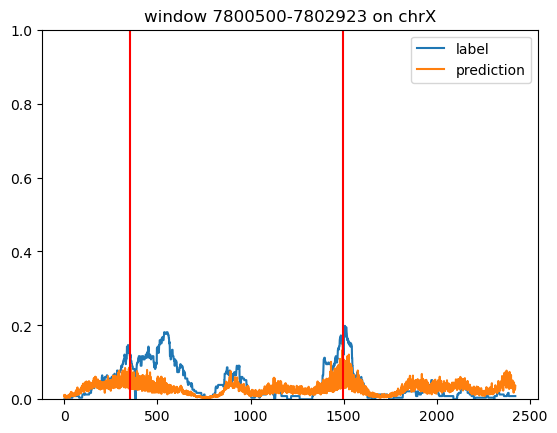

In [312]:
#next peak: chrX all cell types
start=7_800_500
stop=7_802_923
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_ABp)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")#KC_ABp
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

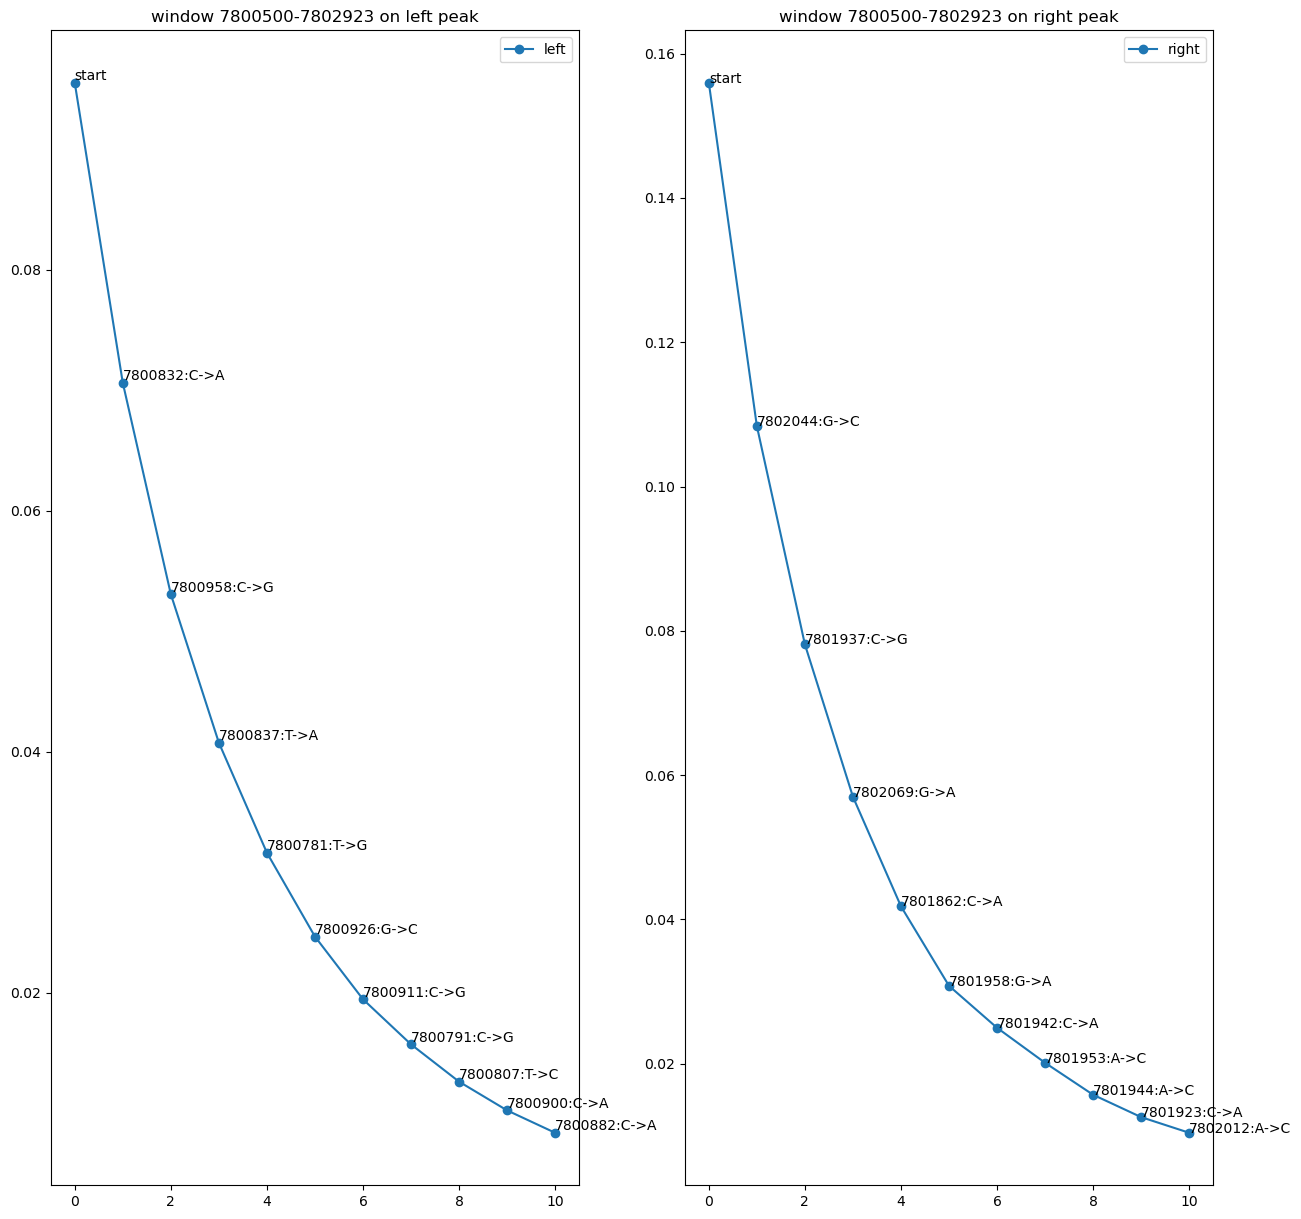

In [48]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_X,modelKC_ABp,real_start_left,10)
result_right=kill_peak_mut(X_X,modelKC_ABp,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

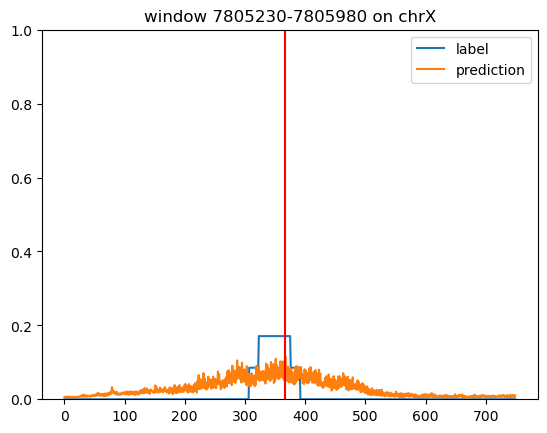

In [70]:
#next peak: chrX KC_G
start=7_805_230
stop=7_805_980
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_AB)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#chiasmglia
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

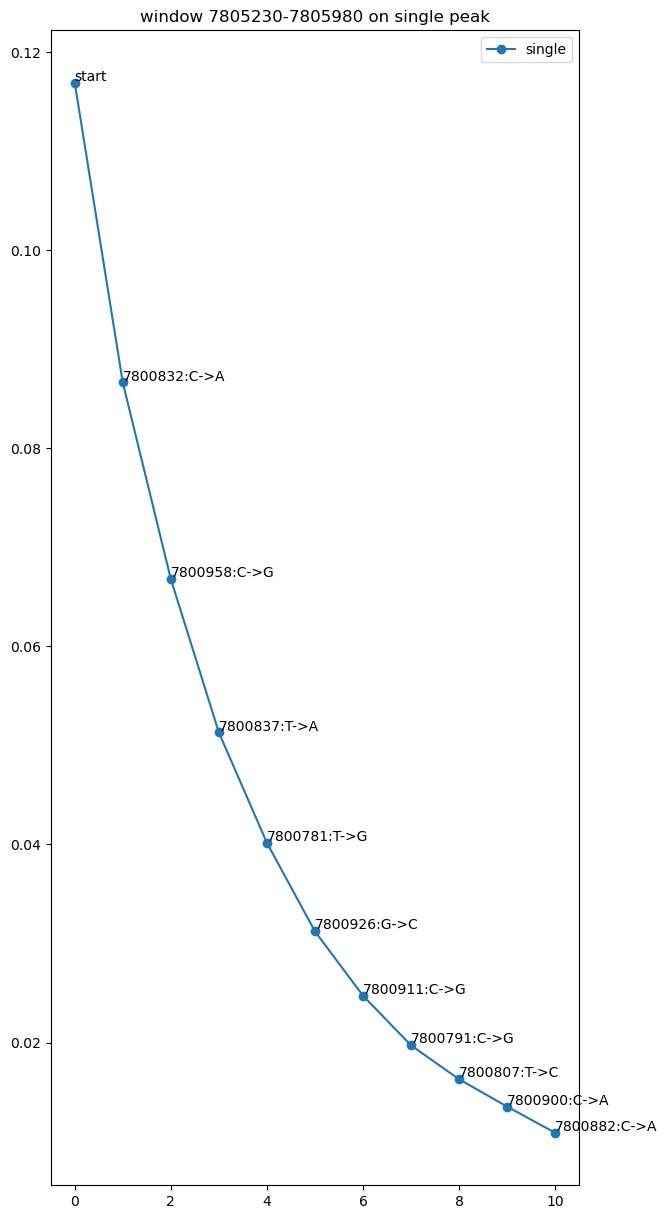

In [71]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelKC_AB,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

slide 4


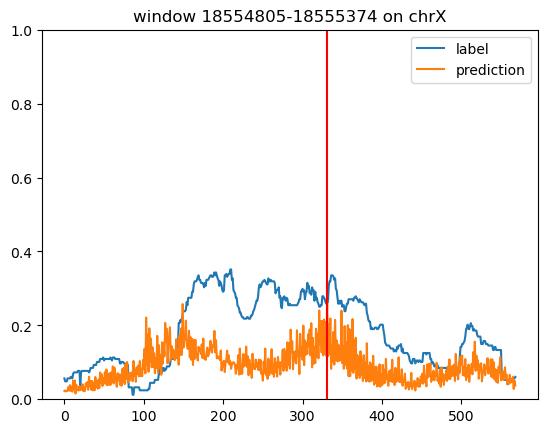

In [74]:
#next peak: chrX KC_AB
start=18_554_805
stop=18_555_374
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_G)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#KC_AB
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

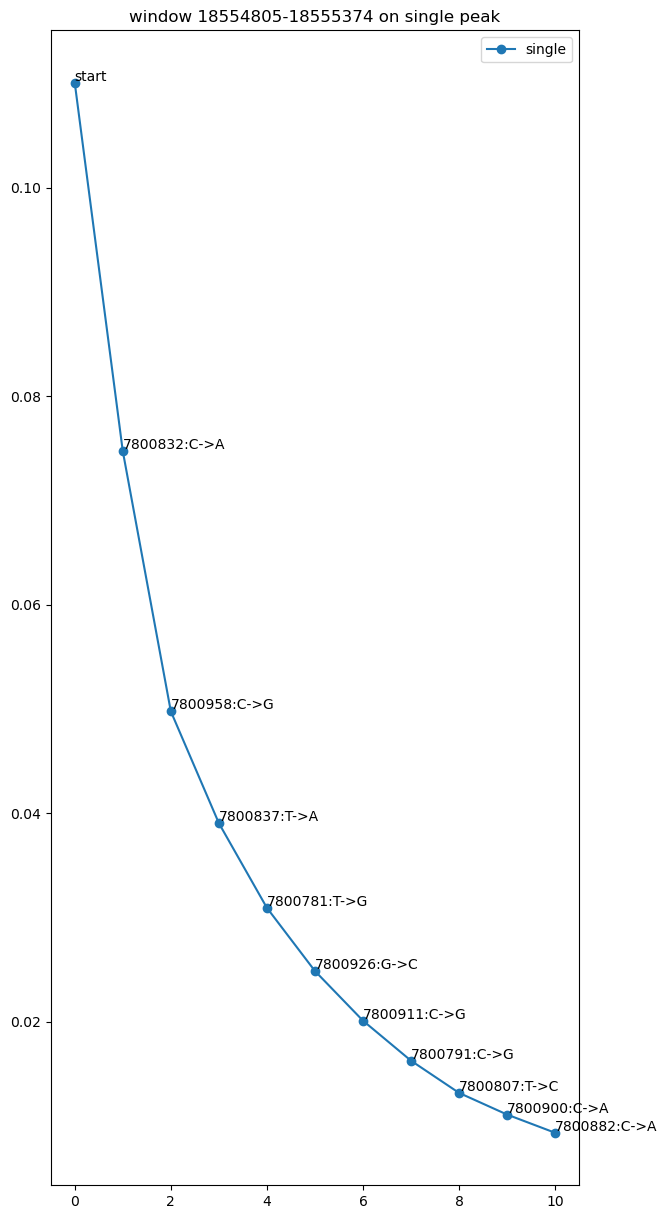

In [75]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelKC_AB,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

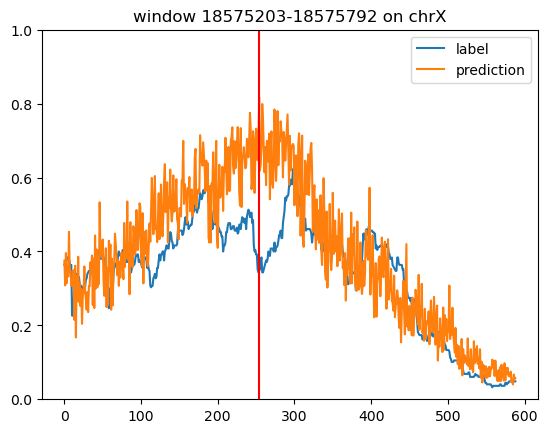

In [77]:
#next peak: chrX KC_G and KC_AB
start=18_575_203
stop=18_575_792
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_G)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#KC_AB
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

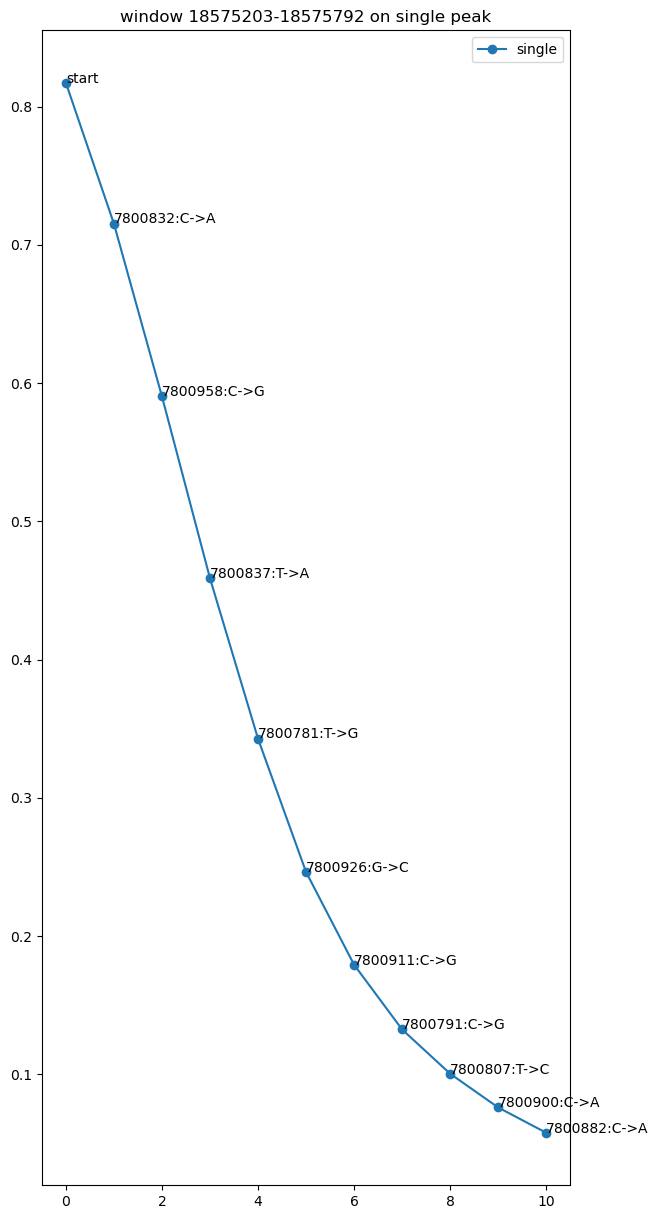

In [78]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelKC_G,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

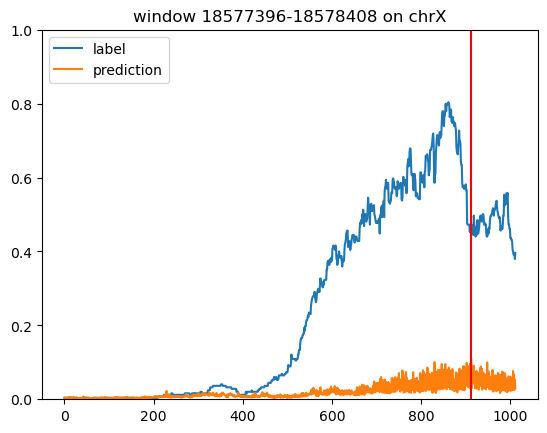

In [94]:
#next peak: chrX KC_AB
start=18_577_396
stop=18_578_408
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelKC_AB)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#KC_AB
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

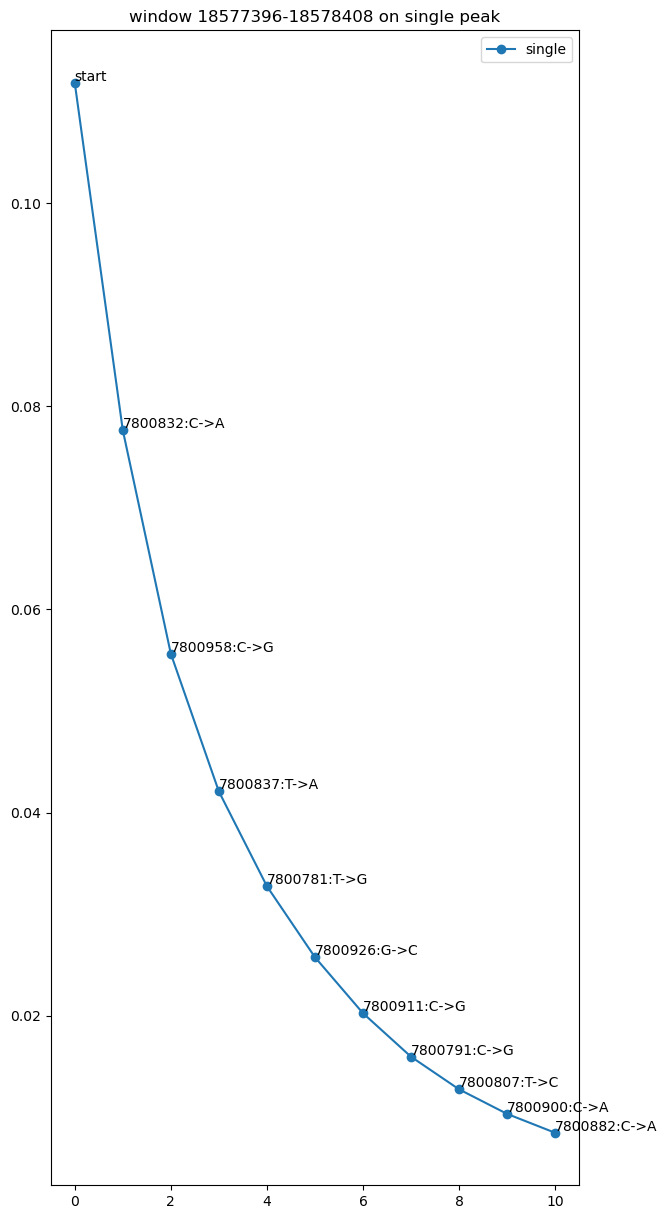

In [95]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelKC_AB,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(x))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

Slide 5

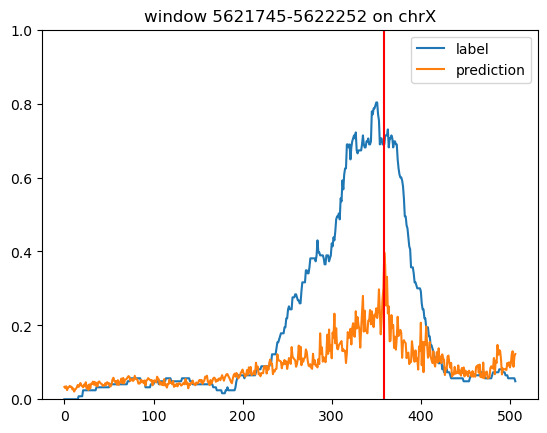

In [111]:
#next peak: chrX all glia
start=5_621_745
stop=5_622_252
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelPhotoreceptors)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_X[start:stop],label="label")#Astrocyte_like
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

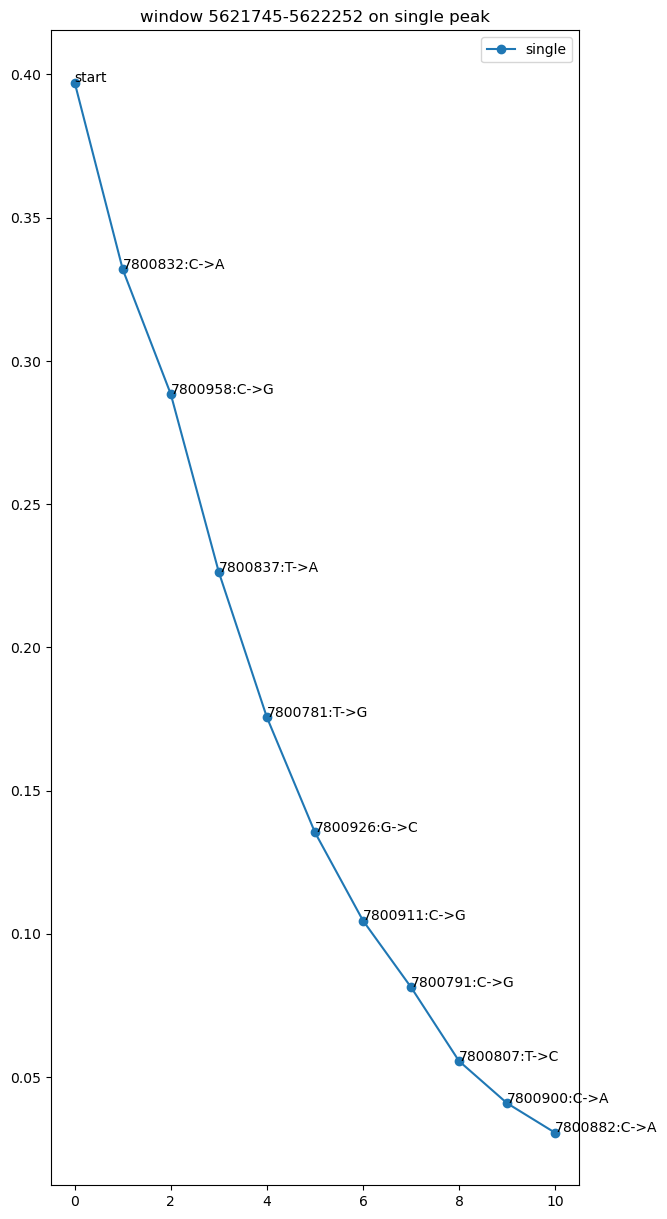

: 

In [113]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_X,modelPhotoreceptors,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(x))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

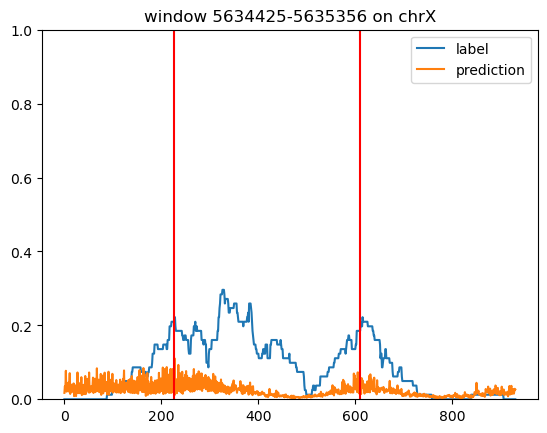

In [17]:
#next peak: chrX T1
start=5_634_425
stop=5_635_356
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelT2)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

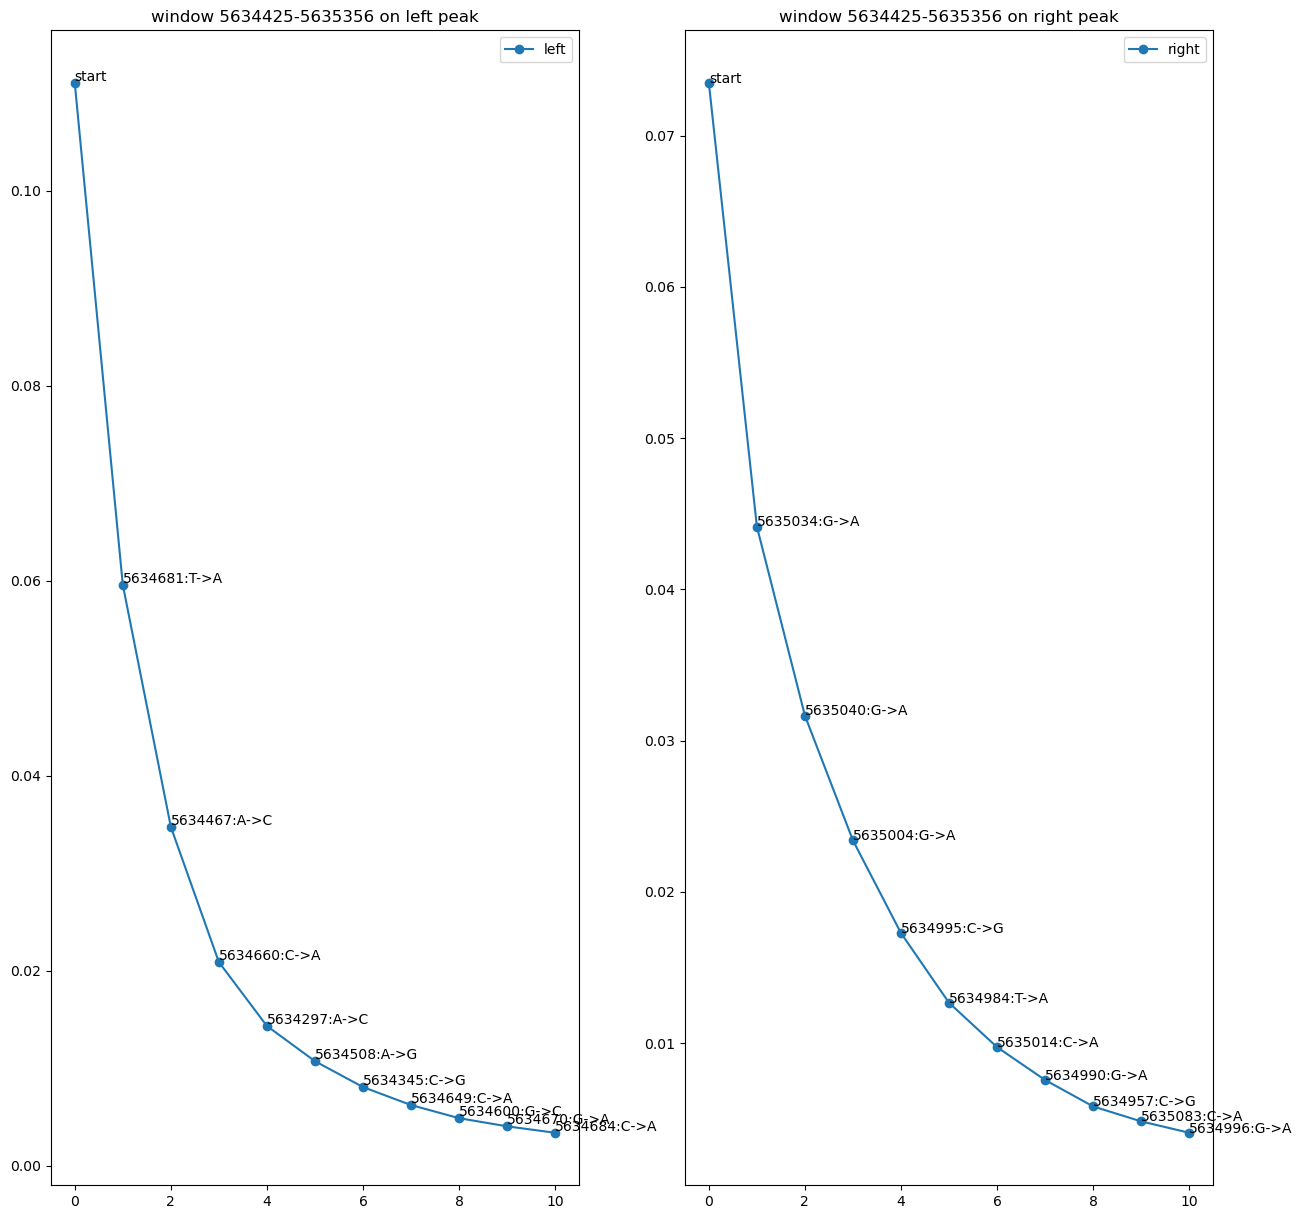

In [22]:
# real_start_left=start+loc_left_max-1000
# real_start_right=start+loc_right_max-1000
# result_left=kill_peak_mut(X_X,modelT2,real_start_left,10)
# result_right=kill_peak_mut(X_X,modelT2,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

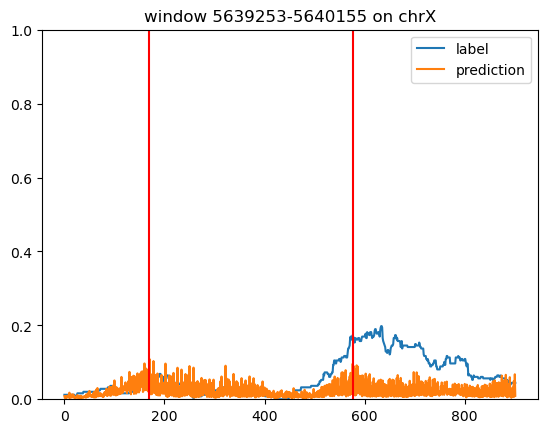

In [32]:
#next peak: chrX all KC_AB
start=5_639_253
stop=5_640_155
L=fast_pred_whole_seq(X_X[start-1000:stop+1000],modelT2)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_X[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

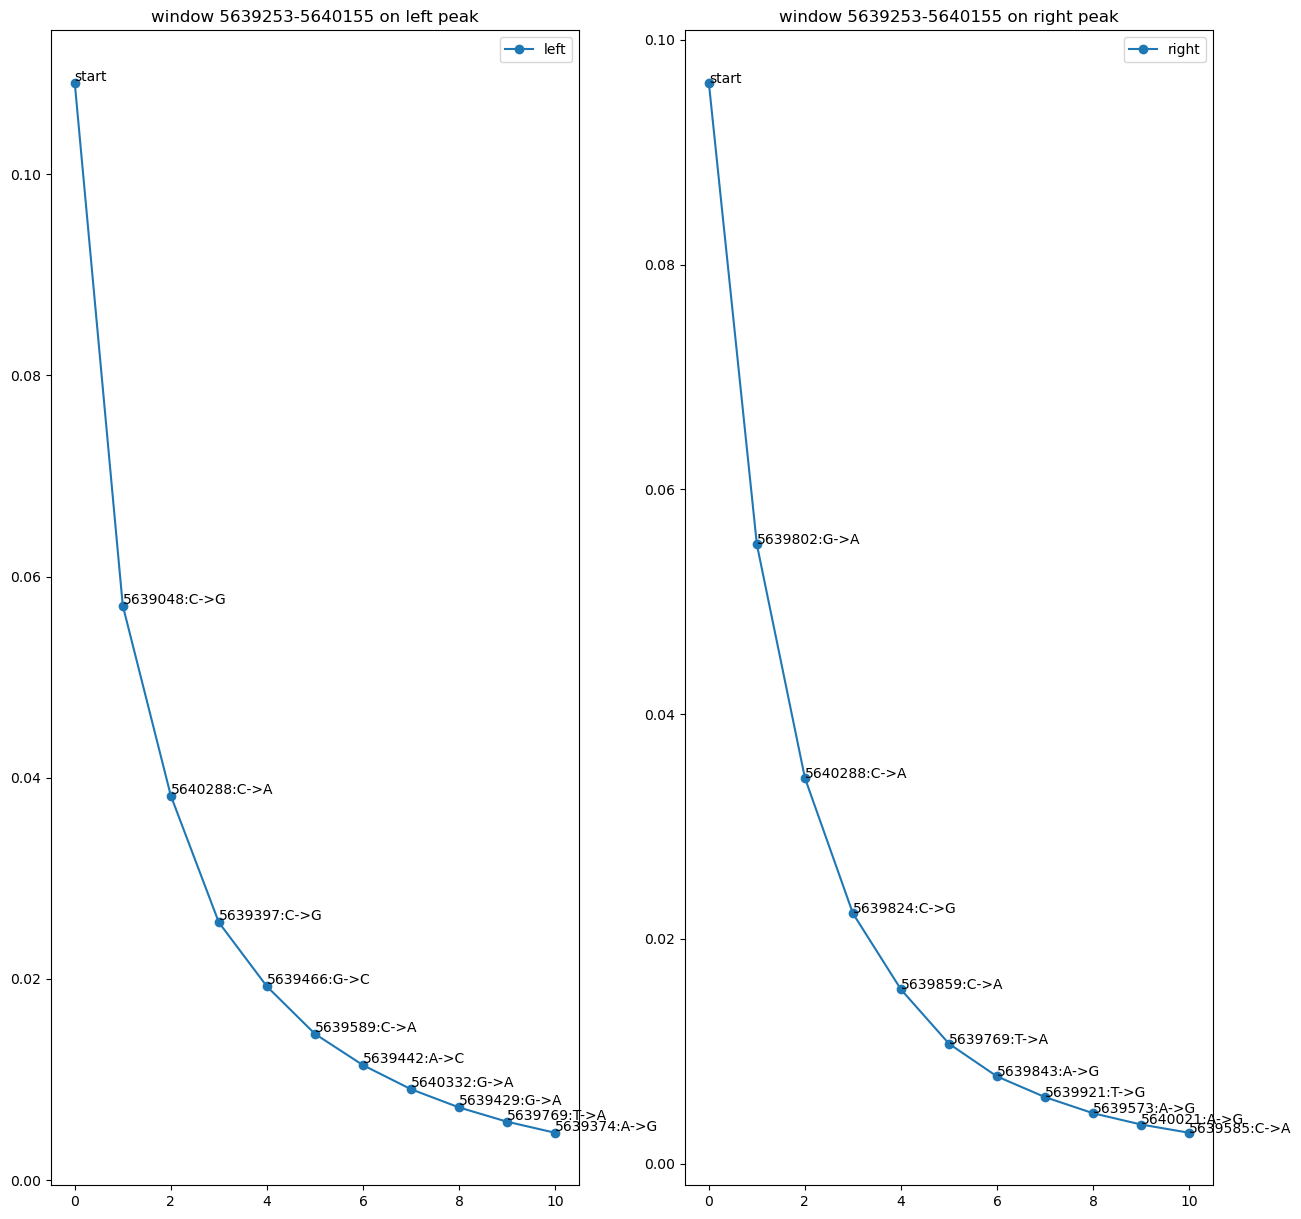

: 

In [34]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_X,modelT2,real_start_left,10)
result_right=kill_peak_mut(X_X,modelT2,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chrX.png")

chr3L

slide 3

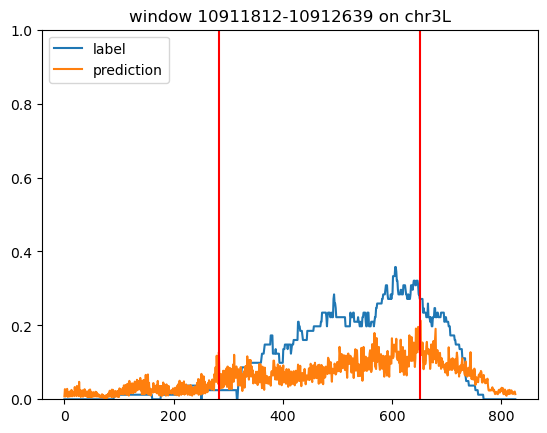

In [23]:
#next peak: chr3L T1
start=10_911_812
stop=10_912_639
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelT3)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chr3L")
os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":window_chr3L.png")

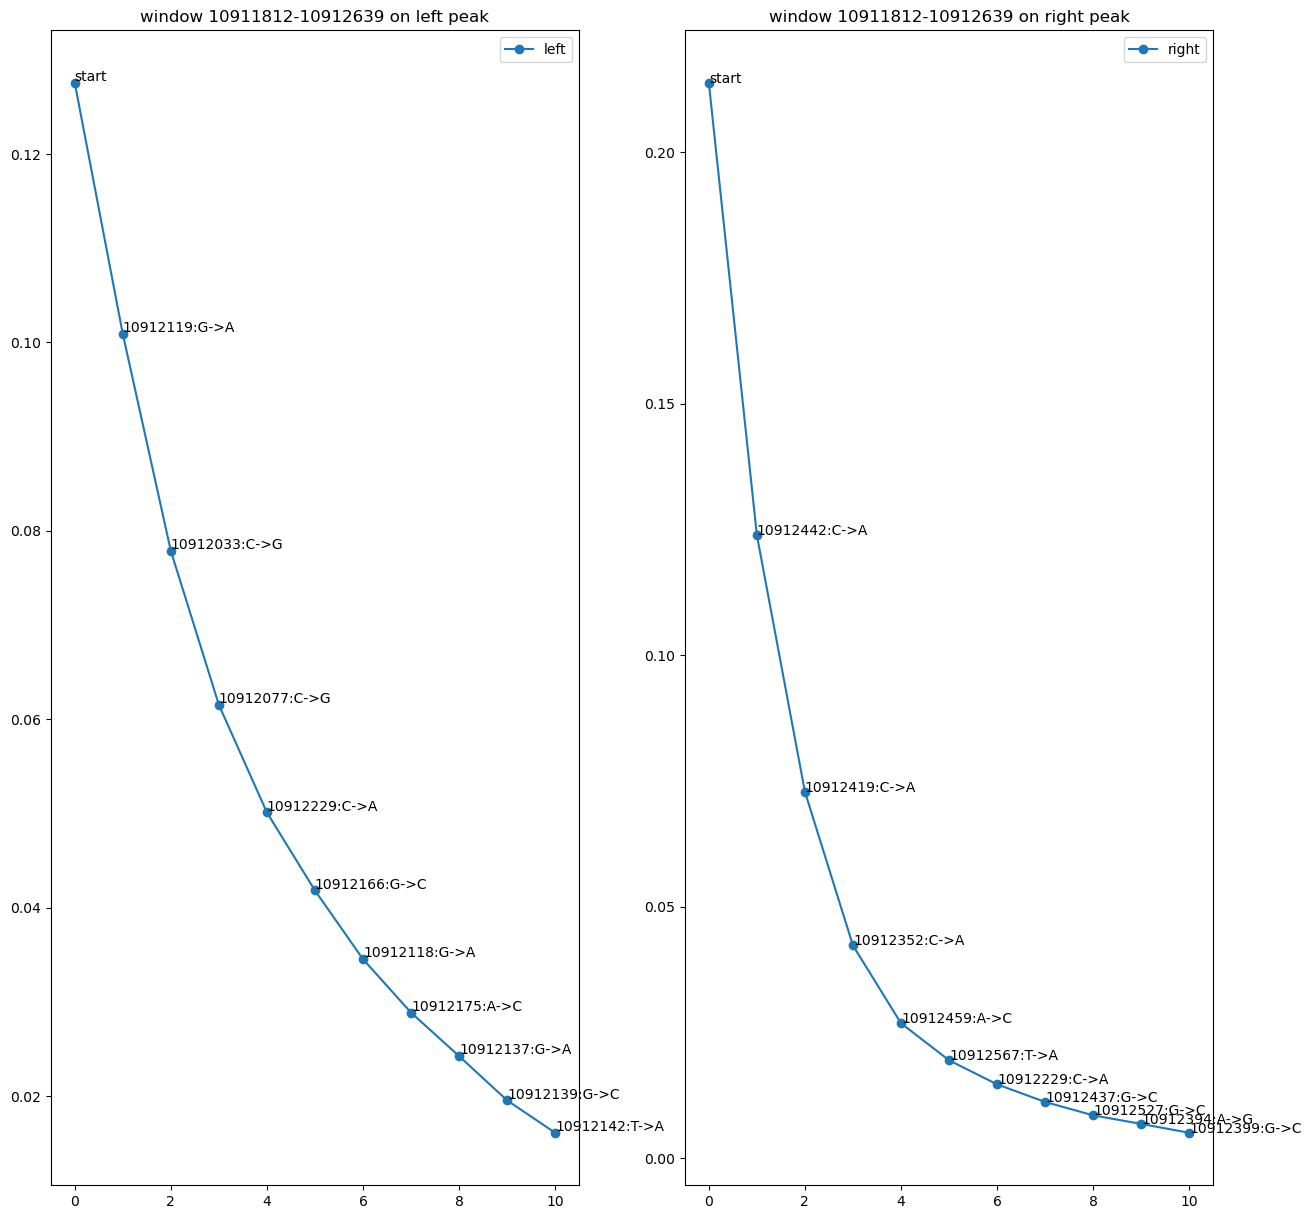

In [25]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_3L,modelT3,real_start_left,10)
result_right=kill_peak_mut(X_3L,modelT3,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")

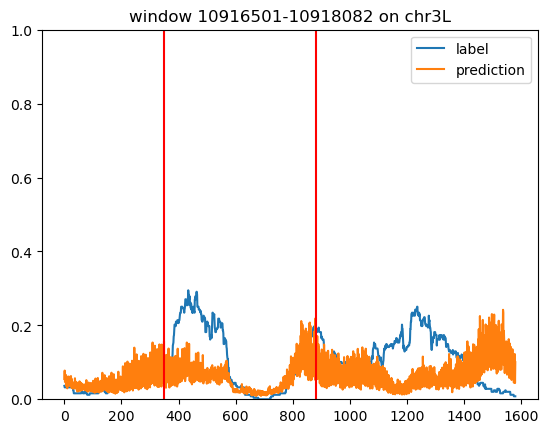

In [70]:
#next peak: chr3L KC_AB and KC_G
start=10_916_501
stop=10_918_082
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelT1)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:-200]).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chr3L")
os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":window_chr3L.png")

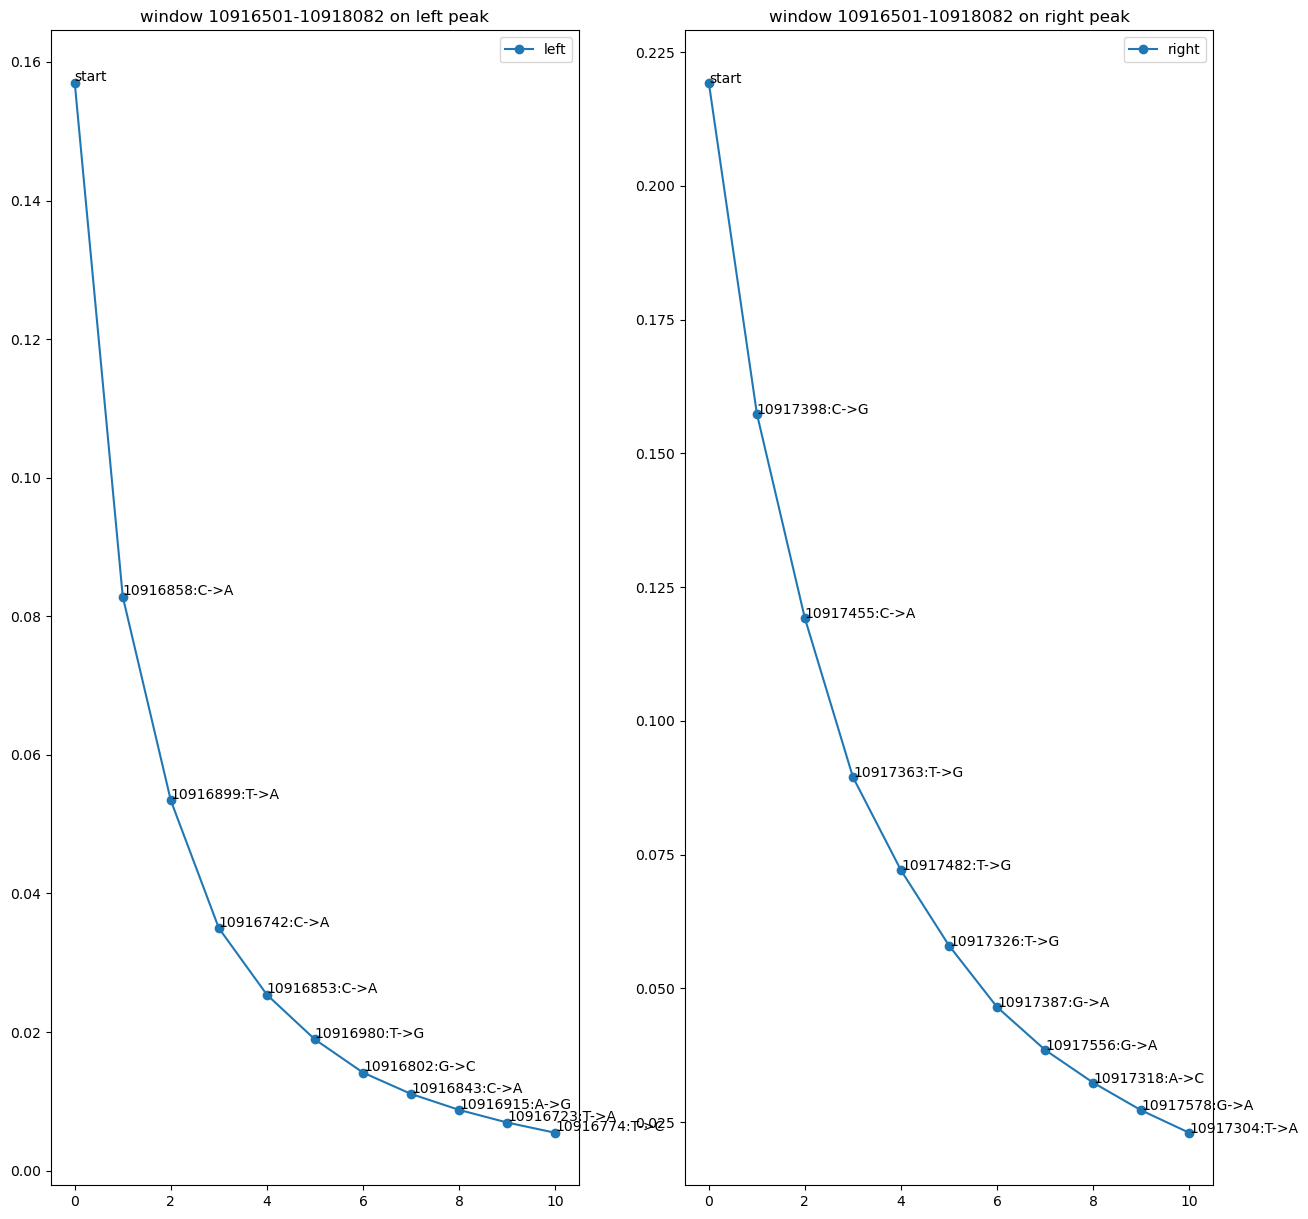

In [72]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_3L,modelT1,real_start_left,10)
result_right=kill_peak_mut(X_3L,modelT1,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")

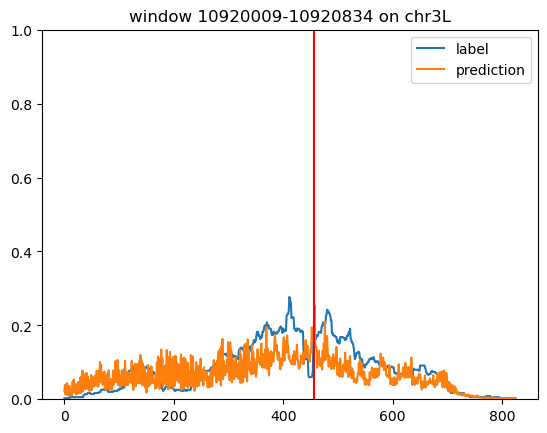

In [89]:
#next peak: chr3L all Ts
start=10_920_009
stop=10_920_834
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelT5)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chr3L")
os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":window_chr3L.png")

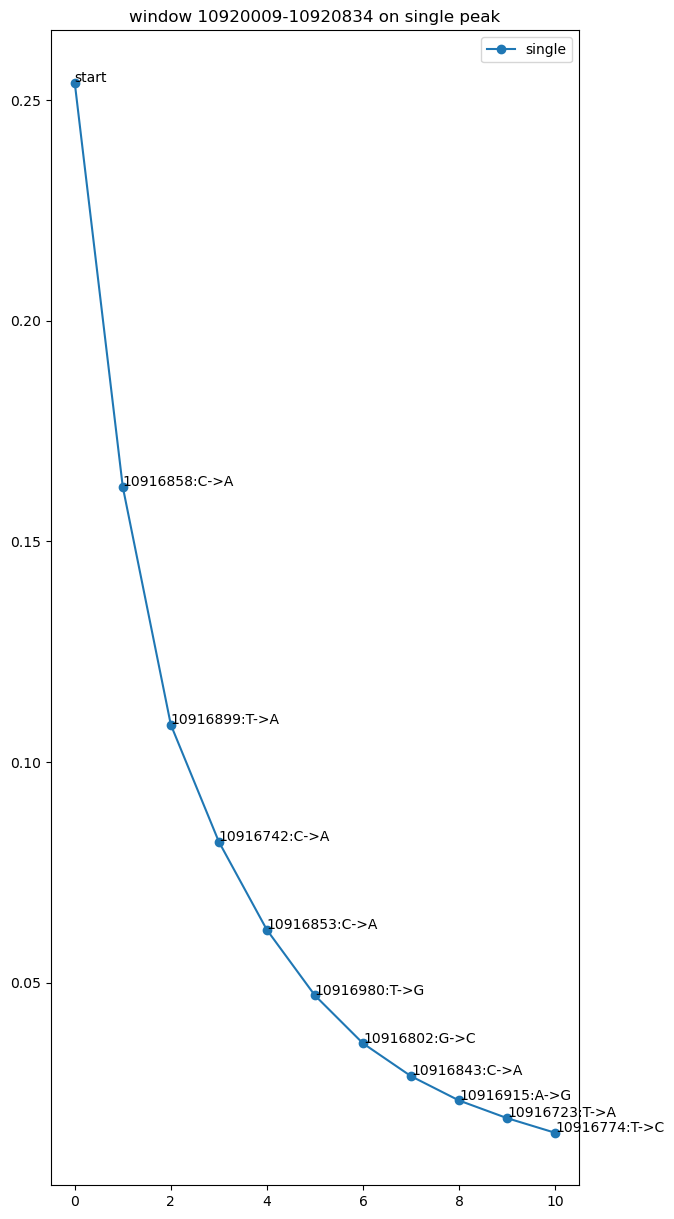

In [90]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_3L,modelT5,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")

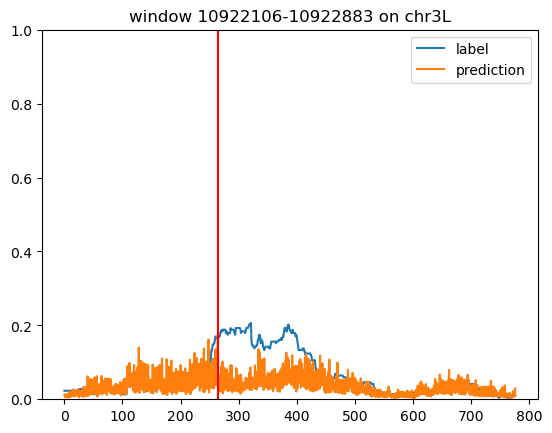

In [102]:
#next peak: chr3L Perineurigalglia and Subperineurialglia
start=10_922_106
stop=10_922_883
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelSubperineurialglia)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chr3L")
os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":window_chr3L.png")

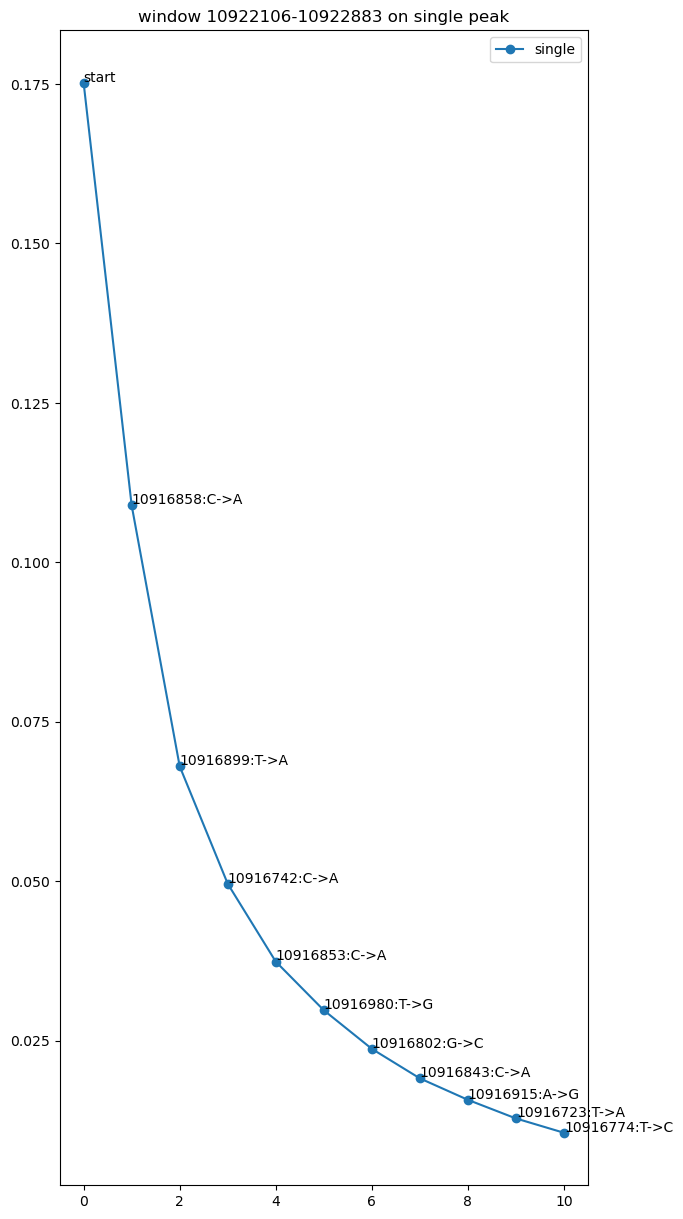

In [103]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_3L,modelSubperineurialglia,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")

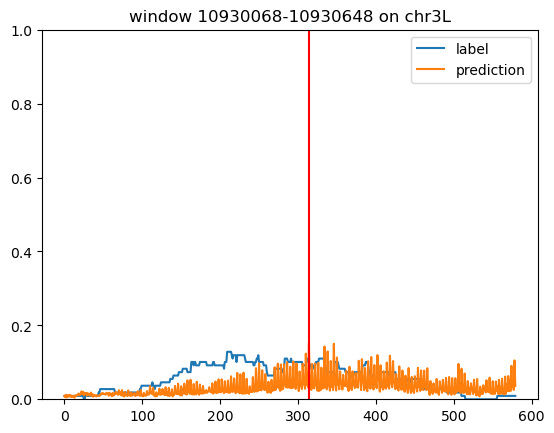

In [132]:
#next peak: chr3L all cell types
start=10_930_068
stop=10_930_648
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelT2a)
L=[i for i in L if i!=0]
loc_max=np.array(L).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chr3L")
os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":window_chr3L.png")

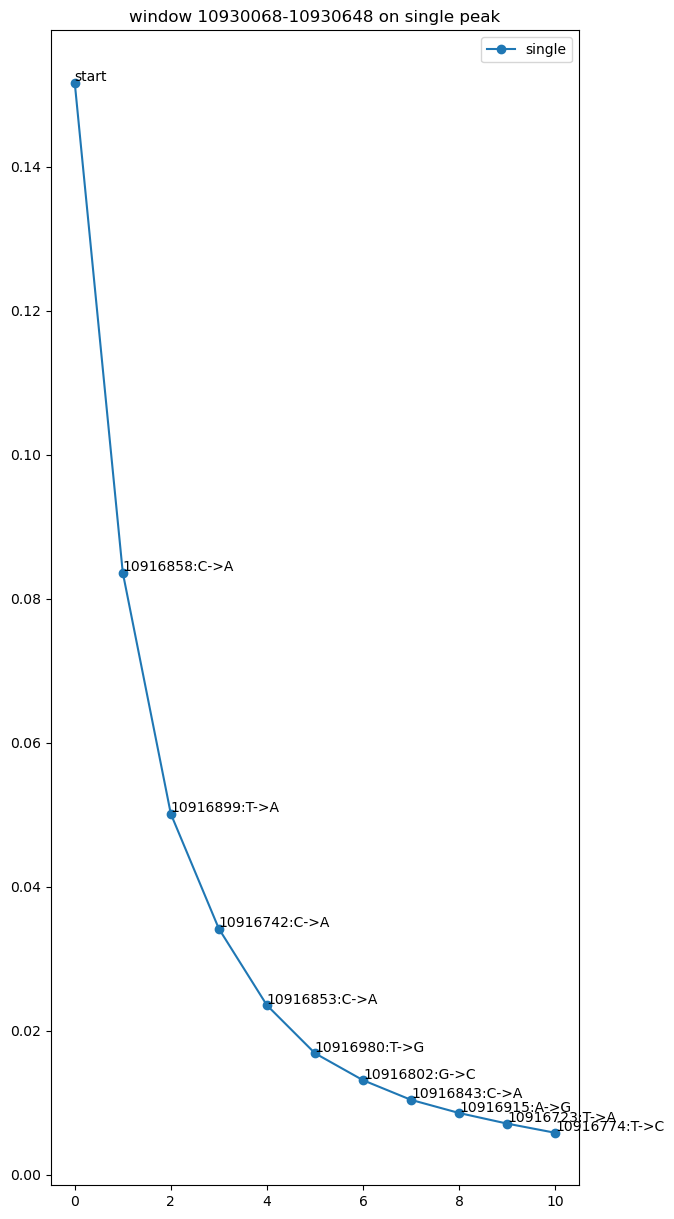

In [133]:
real_start=start+loc_max-1000
result=kill_peak_mut(X_3L,modelT2a,real_start,10)
DIC={}
DIC[str(start)+'-'+str(stop)]=result
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
precise_keys=[i for i in DIC[str(start)+'-'+str(stop)].keys()]
x=np.arange(len(precise_keys))
y=[DIC[global_keys[0]][i] for i in precise_keys]

plt.plot(x,y,label="single",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on single peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")

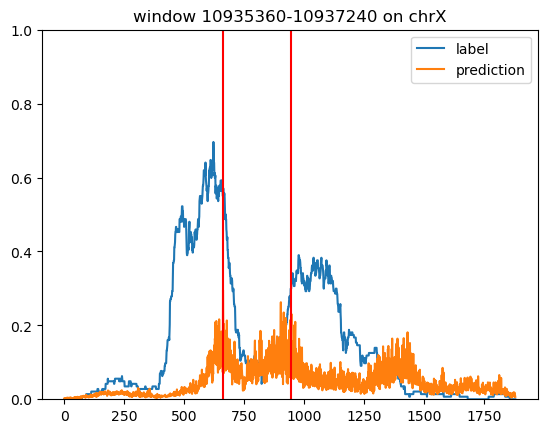

In [136]:
#next peak: chr3L all glia
start=10_935_360
stop=10_937_240
L=fast_pred_whole_seq(X_3L[start-1000:stop+1000],modelPerineurialglia)
L=[i for i in L if i!=0]
mid=len(L)//2
loc_left_max=np.array(L[:mid]).argmax()
loc_right_max=mid+np.array(L[mid:]).argmax()
plt.plot(Y_3L[start:stop],label="label")
plt.ylim(0,1)
plt.plot(L,label="prediction")
plt.legend()
plt.axvline(x=loc_left_max, color='red')
plt.axvline(x=loc_right_max, color='red')
plt.title('window '+str(start)+'-'+str(stop)+" on chrX")
os.chdir('/home/florian/projet/peak_killing/chrX')
plt.savefig(str(start)+'-'+str(stop)+":window_chrX.png")

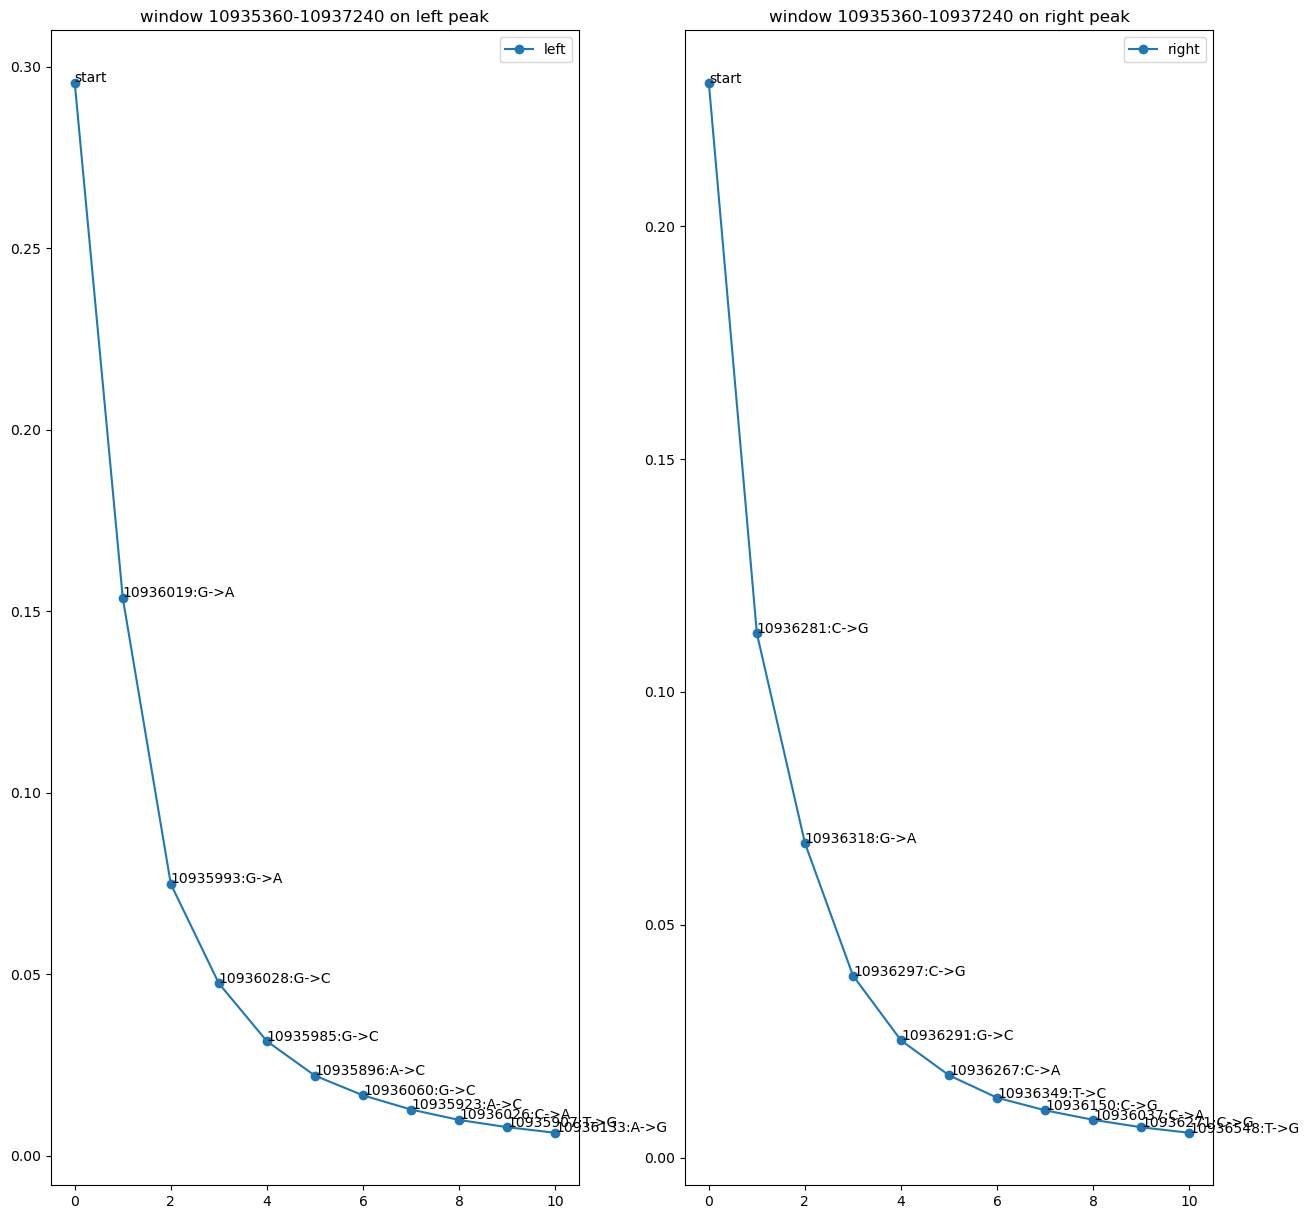

: 

In [139]:
real_start_left=start+loc_left_max-1000
real_start_right=start+loc_right_max-1000
result_left=kill_peak_mut(X_3L,modelPerineurialglia,real_start_left,10)
result_right=kill_peak_mut(X_3L,modelPerineurialglia,real_start_right,10)
DIC={}
DIC[str(start)+'-'+str(stop)+'/left']=result_left
DIC[str(start)+'-'+str(stop)+'/right']=result_right
global_keys=[i for i in DIC.keys()]
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
left_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/left'].keys()]
x=np.arange(len(left_keys))
y=[DIC[global_keys[0]][i] for i in left_keys]

plt.plot(x,y,label="left",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on left peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(left_keys[i], (x[i], y[i] + 0.0002))

plt.subplot(1,2,2)
right_keys=[i for i in DIC[str(start)+'-'+str(stop)+'/right'].keys()]
x=np.arange(len(right_keys))
y=[DIC[global_keys[1]][i] for i in right_keys]

plt.plot(x,y,label="right",marker='o')
plt.title('window '+str(start)+'-'+str(stop)+" on right peak")
plt.legend()
for i in range(len(x)):
    plt.annotate(right_keys[i], (x[i], y[i] + 0.00002))

os.chdir('/home/florian/projet/peak_killing/chr3L')
plt.savefig(str(start)+'-'+str(stop)+":peaks_chr3L.png")